Use data science 3 image

# Installs

In [ ]:
!pip install torch tenseal numpy scikit-learn torchvision torchmetrics imblearn matplotlib "pandas<=2.0.0"


In [3]:
import sys
print(sys.version)

3.10.6 (main, Oct  7 2022, 20:19:58) [GCC 11.2.0]


In [10]:
import os
os.getcwd()

'/root/cci_maria_priv'

# Imports

In [3]:
import torch
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, AUROC
from torch.utils.data import Dataset
import tenseal as ts
import pandas as pd
import random
from time import time
import pickle
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import tqdm as tqdm

import random

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Variables

In [11]:
seed = 0
#n_features = 30
n_features = 20
threshold = 0.5
learning_rate = 1e-2
momentum = 0.9
train_data_path = "cci_maria_priv/Topic_classification_5classes/embeddings_rb_train5classes_20pca.pkl"
test_data_path = "cci_maria_priv//Topic_classification_5classes/embeddings_rb_test5classes_20pca.pkl"

In [6]:
# learning rate
print(format(learning_rate, 'f'))

0.010000


# Helpers

In [5]:
def set_seed(seed=seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Data loader

In [6]:
def mydata(embedding_fp, target_label=0, num_samples=10000, seed=5, n_features=n_features, balance=False):
    # read the file
    with open(embedding_fp, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_labels = stored_data['labels']
        stored_embeddings = stored_data['embeddings']
    # convert into a dataframe
    df = pd.DataFrame(pd.DataFrame(data = stored_embeddings))
    print('Data frame length', len(df))
    df['label'] = stored_labels.tolist()
    
    # rename the labels as one vs all
    labels = np.arange(5)
    dict0 = dict(zip(labels, np.zeros(5, dtype=np.int64)))
    dict0[target_label] = 1

    print('label lookup', dict0)
    
    df.label = df.label.replace(dict0)
    
    #display(df)
    
    # select a subset of features
#    X = df.iloc[:,0:n_features].values
#    y = df.label.values  
 
    
    X = df.iloc[:,0:n_features].sample(10000, random_state=5).values
    y = df.label.sample(10000, random_state=5).values 


    if balance:
#        rus = RandomUnderSampler(random_state=seed, replacement=True)
#        X, y = rus.fit_resample(X, y)
        
        smote = SMOTE(random_state=15)
        X,y = smote.fit_resample(X, y)
    
    if num_samples is not None:
        # resample data
        df = df.sample(num_samples, random_state=seed)
    
    print('y dist', Counter(y))
    
    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y).unsqueeze(-1)
    
    print('y shape', y.shape, y.dtype)
    print('x shape', X.shape, X.dtype)
    
    return X, y

# Load training data

In [12]:
train_data = mydata(train_data_path, balance=True, n_features=20)
X_train, y_train = train_data

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3c92722710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Data frame length 67099
label lookup {0: 1, 1: 0, 2: 0, 3: 0, 4: 0}
y dist Counter({0: 6197, 1: 6197})
y shape torch.Size([12394, 1]) torch.float32
x shape torch.Size([12394, 20]) torch.float32


In [9]:
## 12'394 - smote #10000
##12'422  - rus  #16200

# Load test data

In [13]:
test_data = mydata(test_data_path, balance=False, num_samples=None, n_features=n_features)
X_test, y_test = test_data

Data frame length 16775
label lookup {0: 1, 1: 0, 2: 0, 3: 0, 4: 0}
y dist Counter({0: 6167, 1: 3833})
y shape torch.Size([10000, 1]) torch.float32
x shape torch.Size([10000, 20]) torch.float32


## Training a Logistic Regression Model without encryption

## Model

In [14]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

## Metrics

In [15]:
acc_fn = BinaryAccuracy(threshold=threshold)
f1_fn = BinaryF1Score(threshold=threshold)
auroc_fn = AUROC(task="binary")
pre_fn = BinaryPrecision(threshold=threshold)
recall_fn = BinaryRecall(threshold=threshold)

## Train

In [11]:
def train(model, optim, criterion, x, y, x_test, y_test, epochs=100):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        train_loss_hist.append(loss.item())
        loss.backward()
        optim.step()
        acc = acc_fn(out, y)
        f1 = f1_fn(out, y)
        auroc = auroc_fn(out, y)
        pre = pre_fn(out,y)
#        print(f"Loss train data at epoch {e}: {loss.data}| Acc: {acc.data:.5f}% | Precision: {pre.data:.5f}% | F1-score: {f1.data:.5f}% | AUROC: {auroc.data:.5f}%")
               
        out_test = model(x_test)
        loss_test = criterion(out_test, y_test)
        test_loss_hist.append(loss_test.item())
        acc_ = acc_fn(out_test, y_test)
        f1_ = f1_fn(out_test, y_test)
        auroc_ = auroc_fn(out_test, y_test)
        pre_ = pre_fn(out_test, y_test)
        re_ = recall_fn(out_test, y_test)
        
        print(f"Loss test data at epoch {e}: {loss_test.data:.4f} | Accuracy: {acc_.data:.4f}% |Precision: {pre_.data:.4f}% | F1-score: {f1_.data:.4f}% | AUROC: {auroc_.data:.4f}%")
    
    return model

### PCA 20 - SMOTE

In [21]:
learning_rate = 0.001

In [22]:
t_start = time()

set_seed()
test_loss_hist = []
train_loss_hist = []
epochs = 1000
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

model = train(model, optim, criterion, X_train, y_train, X_test, y_test, epochs=epochs) 

t_end = time()
print(f"\nPlain model training took: {int(t_end - t_start)} seconds")

Loss test data at epoch 1: 1.1835 | Accuracy: 0.4055% |Precision: 0.2993% | F1-score: 0.3463% | AUROC: 0.3675%
Loss test data at epoch 2: 1.1698 | Accuracy: 0.4101% |Precision: 0.3040% | F1-score: 0.3520% | AUROC: 0.3736%
Loss test data at epoch 3: 1.1506 | Accuracy: 0.4171% |Precision: 0.3104% | F1-score: 0.3592% | AUROC: 0.3824%
Loss test data at epoch 4: 1.1267 | Accuracy: 0.4256% |Precision: 0.3184% | F1-score: 0.3684% | AUROC: 0.3939%
Loss test data at epoch 5: 1.0988 | Accuracy: 0.4343% |Precision: 0.3264% | F1-score: 0.3775% | AUROC: 0.4077%
Loss test data at epoch 6: 1.0679 | Accuracy: 0.4444% |Precision: 0.3357% | F1-score: 0.3880% | AUROC: 0.4241%
Loss test data at epoch 7: 1.0345 | Accuracy: 0.4544% |Precision: 0.3455% | F1-score: 0.3995% | AUROC: 0.4426%
Loss test data at epoch 8: 0.9994 | Accuracy: 0.4690% |Precision: 0.3586% | F1-score: 0.4136% | AUROC: 0.4633%
Loss test data at epoch 9: 0.9633 | Accuracy: 0.4831% |Precision: 0.3729% | F1-score: 0.4313% | AUROC: 0.4859%
L

In [39]:
# lr = 0.1
# Loss test data at epoch 500: 0.2447 | Accuracy: 0.9015% |Precision: 0.8574% | F1-score: 0.8740% | AUROC: 0.9637%

# lr = 0.01
#Loss test data at epoch 500: 0.2459 | Accuracy: 0.9014% |Precision: 0.8554% | F1-score: 0.8742% | AUROC: 0.9638%
#Loss test data at epoch 1000: 0.2448 | Accuracy: 0.9015% |Precision: 0.8574% | F1-score: 0.8740% | AUROC: 0.9637%

# lr = 0.001
#Loss test data at epoch 500: 0.2561 | Accuracy: 0.8989% |Precision: 0.8457% | F1-score: 0.8723% | AUROC: 0.9637%
#Loss test data at epoch 500: 0.2561 | Accuracy: 0.8989% |Precision: 0.8457% | F1-score: 0.8723% | AUROC: 0.9637%

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


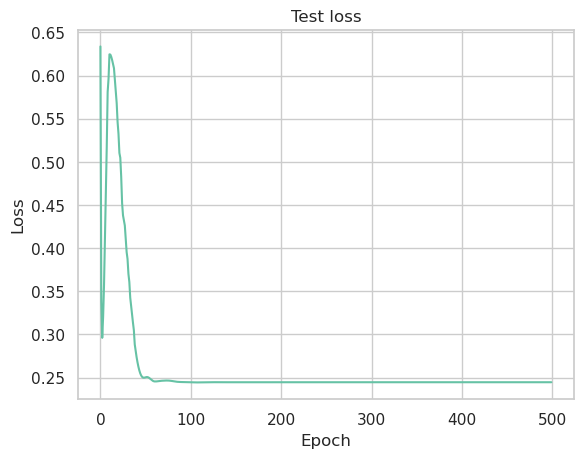

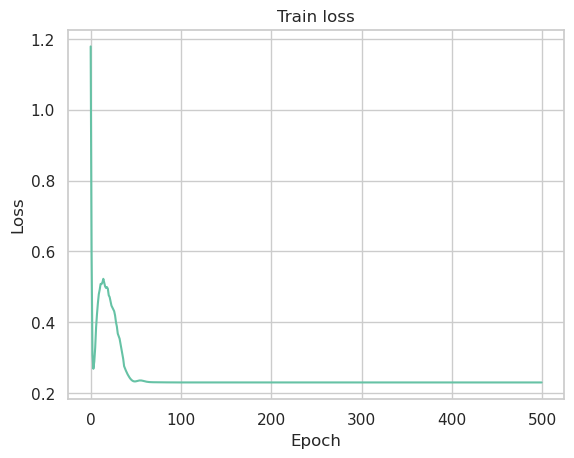

In [16]:
# lr = 0.1

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


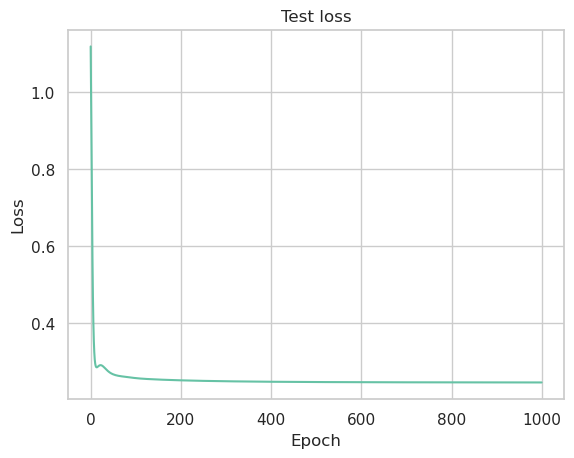

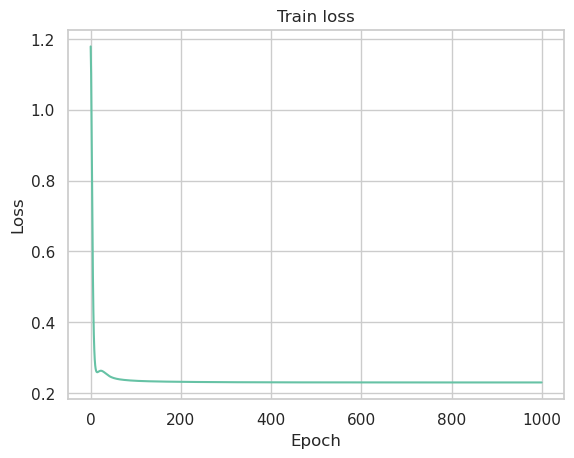

In [20]:
# lr = 0.01

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


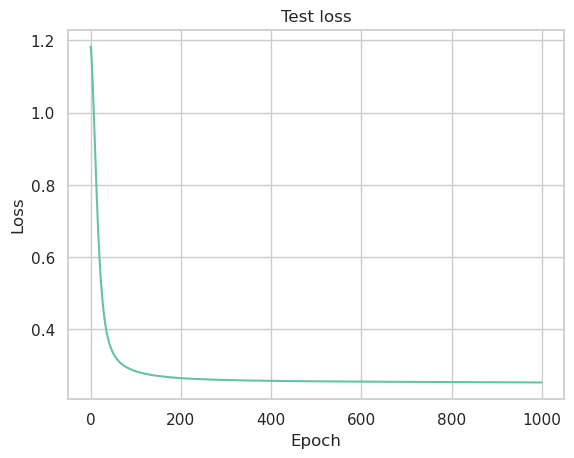

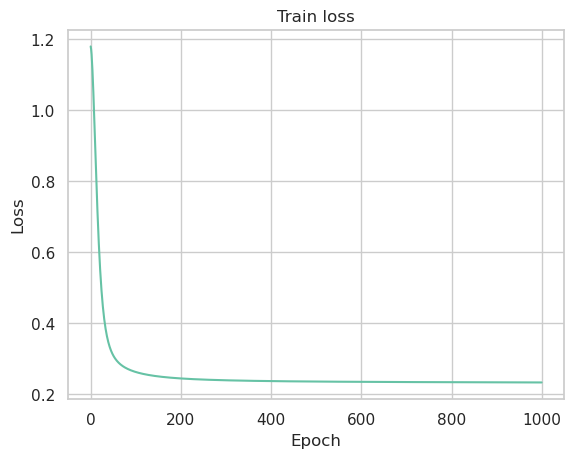

In [23]:
# lr = 0.001

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Random Undersampler

In [47]:
### Comparing with  - 20 pca
learning_rate = 0.1

In [48]:
t_start = time()

set_seed()
test_loss_hist = []
train_loss_hist = []
epochs = 500
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

model = train(model, optim, criterion, X_train, y_train, X_test, y_test, epochs=epochs) 

t_end = time()
print(f"\nPlain model training took: {int(t_end - t_start)} seconds")

Loss test data at epoch 1: 0.6329 | Accuracy: 0.6691% |Precision: 0.5507% | F1-score: 0.6322% | AUROC: 0.7493%
Loss test data at epoch 2: 0.3346 | Accuracy: 0.8635% |Precision: 0.7850% | F1-score: 0.8328% | AUROC: 0.9378%
Loss test data at epoch 3: 0.2936 | Accuracy: 0.8925% |Precision: 0.8324% | F1-score: 0.8653% | AUROC: 0.9525%
Loss test data at epoch 4: 0.3194 | Accuracy: 0.8916% |Precision: 0.8350% | F1-score: 0.8634% | AUROC: 0.9540%
Loss test data at epoch 5: 0.3574 | Accuracy: 0.8894% |Precision: 0.8318% | F1-score: 0.8607% | AUROC: 0.9542%
Loss test data at epoch 6: 0.4093 | Accuracy: 0.8873% |Precision: 0.8294% | F1-score: 0.8581% | AUROC: 0.9545%
Loss test data at epoch 7: 0.4536 | Accuracy: 0.8869% |Precision: 0.8295% | F1-score: 0.8574% | AUROC: 0.9552%
Loss test data at epoch 8: 0.5147 | Accuracy: 0.8852% |Precision: 0.8266% | F1-score: 0.8555% | AUROC: 0.9560%
Loss test data at epoch 9: 0.5432 | Accuracy: 0.8860% |Precision: 0.8269% | F1-score: 0.8566% | AUROC: 0.9570%
L

In [ ]:

# lr = 0.1
#Loss test data at epoch 500: 0.2465 | Accuracy: 0.8996% |Precision: 0.8518% | F1-score: 0.8722% | AUROC: 0.9639%

# lr = 0.01
#Loss test data at epoch 500: 0.2477 | Accuracy: 0.8997% |Precision: 0.8502% | F1-score: 0.8726% | AUROC: 0.9640%
#Loss test data at epoch 1000: 0.2466 | Accuracy: 0.8994% |Precision: 0.8514% | F1-score: 0.8719% | AUROC: 0.9639%

#lr = 0.001
#Loss test data at epoch 1000: 0.2546 | Accuracy: 0.8981% |Precision: 0.8413% | F1-score: 0.8719% | AUROC: 0.9641%

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


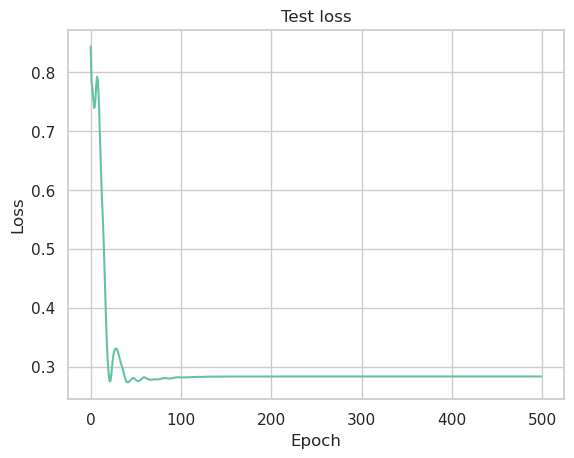

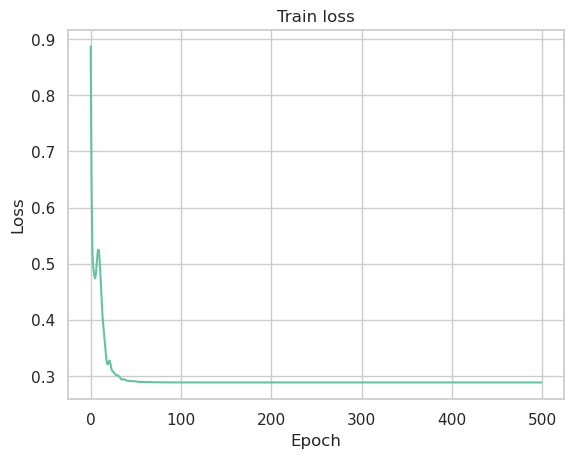

In [75]:
# lr = 0.1

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


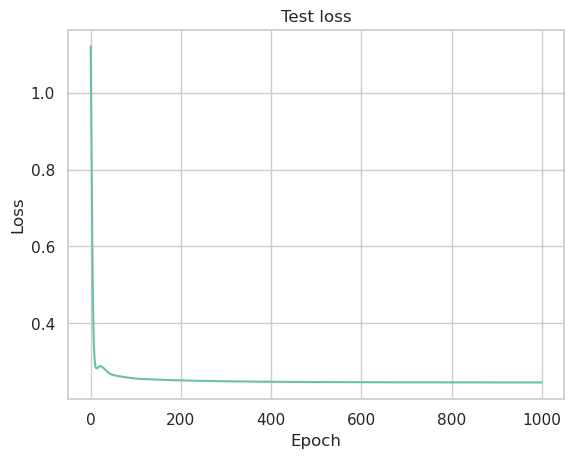

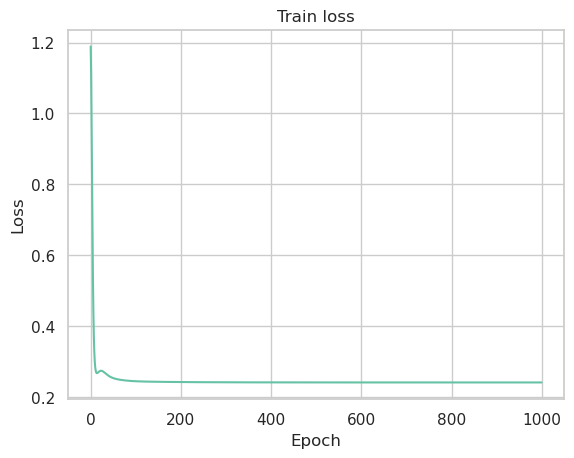

In [43]:
# lr = 0.01

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


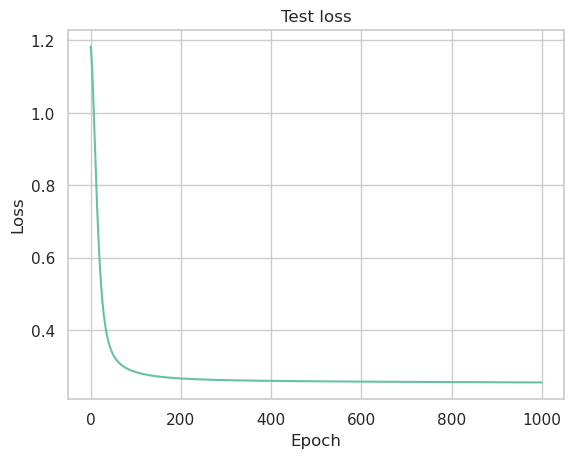

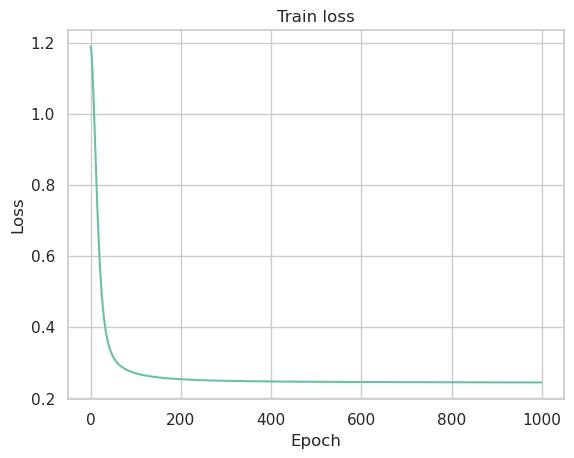

In [46]:
# lr = 0.001

plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Training an Encrypted Logistic Regression Model on Encrypted Data

In [16]:
# Polynomial 1

class EncryptedLR:
    
    def __init__(self, torch_lr , is_encrypted=True, approx_sigmoid=True, learning_rate=None, l1=0.002):
        
        self.is_encrypted = is_encrypted
        self.approx_sigmoid = approx_sigmoid
        self.learning_rate = learning_rate
        self.l1 = l1
        
        if is_encrypted:
            self.weight = torch_lr.lr.weight.data.tolist()[0]
            self.bias = torch_lr.lr.bias.data.tolist()
        else:
            self.weight = torch_lr.lr.weight[0].clone().detach()
            self.bias = torch_lr.lr.bias.clone().detach()
        
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = self.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
#        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        
        if self.learning_rate is None:
            self.weight -= self._delta_w * (1 / self._count) + self.weight * self.l1
            self.bias -= self._delta_b * (1 / self._count)
        else:
            self.weight -= self._delta_w * self.learning_rate + self.weight * self.l1
            self.bias -= self._delta_b * self.learning_rate
        
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        

        # store class
    def store_data(self):
        with open("enc_data_class5.pkl", "wb") as f:
            pickle.dump({'enc_data': self}, f)
             
        joblib.dump(self, './enc_data_class5.joblib')
    
    def sigmoid(self, enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        if self.is_encrypted:
            return enc_x.polyval([0.5, 0.197, 0, -0.004])
        else:
            if self.approx_sigmoid:
                return 0.5 + (0.197 * enc_x) - (0.004 * enc_x**3)
            else:
                return torch.sigmoid(enc_x)
    
    def bce_loss(self, x_test,  y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b)#.reshape(-1, 1)
#        print(out.shape)
#        print(y_test[:, 0].shape)
        loss = torch.nn.BCELoss()
        loss_value = loss(out, y_test[:, 0])
  
        return loss_value
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        acc = acc_fn(out, y_test)        
        return acc
    
    def plain_f1score(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        f1 = f1_fn(out, y_test)
        return f1
    
    def plain_precision(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        pre = pre_fn(out, y_test)
        return pre
    
    def plain_auroc(self, X_test, y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)

        out = torch.sigmoid(X_test.matmul(w) + b)
        
        auc = auroc_fn(out, y_test) 
        return auc   
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [12]:
# Polynomial 2

class EncryptedLR:
    
    def __init__(self, torch_lr , is_encrypted=True, approx_sigmoid=True, learning_rate=None, l1=0.005):
        
        self.is_encrypted = is_encrypted
        self.approx_sigmoid = approx_sigmoid
        self.learning_rate = learning_rate
        self.l1 = l1
        
        if is_encrypted:
            self.weight = torch_lr.lr.weight.data.tolist()[0]
            self.bias = torch_lr.lr.bias.data.tolist()
        else:
            self.weight = torch_lr.lr.weight[0].clone().detach()
            self.bias = torch_lr.lr.bias.clone().detach()
        
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = self.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
#        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        
        if self.learning_rate is None:
            self.weight -= self._delta_w * (1 / self._count) + self.weight * self.l1
            self.bias -= self._delta_b * (1 / self._count)
        else:
            self.weight -= self._delta_w * self.learning_rate + self.weight * self.l1
            self.bias -= self._delta_b * self.learning_rate
        
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        

        # store class
    def store_data(self):
        with open("enc_data_class5.pkl", "wb") as f:
            pickle.dump({'enc_data': self}, f)
             
        joblib.dump(self, './enc_data_class5.joblib')
    
    def sigmoid(self, enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        if self.is_encrypted:
            return enc_x.polyval([0.500781, 0.14670403, 0.001198, -0.001006])
        else:
            if self.approx_sigmoid:
                return 0.500781 + (0.14670403 * enc_x) + (0.001198 * enc_x**2) - (0.001006 * enc_x**3)
            else:
                return torch.sigmoid(enc_x)
    
    def bce_loss(self, x_test,  y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b)#.reshape(-1, 1)
#        print(out.shape)
#        print(y_test[:, 0].shape)
        loss = torch.nn.BCELoss()
        loss_value = loss(out, y_test[:, 0])
  
        return loss_value
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        acc = acc_fn(out, y_test)        
        return acc
    
    def plain_f1score(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        f1 = f1_fn(out, y_test)
        return f1
    
    def plain_precision(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        pre = pre_fn(out, y_test)
        return pre
    
    def plain_auroc(self, X_test, y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)

        out = torch.sigmoid(X_test.matmul(w) + b)
        
        auc = auroc_fn(out, y_test) 
        return auc   
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

## encryption params

In [17]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_train = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_train.global_scale = 2 ** 21
ctx_train.generate_galois_keys()

## encrypt data

In [18]:
t_start = time()

def encrypt_data(X, ctx_train):
    enc_X = []

    for i in tqdm.tqdm(range(len(X)), desc='Encrypt train data'):
        x = X[i]
        x_enc = ts.ckks_vector(ctx_train, x.tolist())
        enc_X.append(x_enc)

    t_end = time()
    
    return enc_X

enc_x_train = encrypt_data(X_train, ctx_train)
enc_x_test = encrypt_data(X_test, ctx_train)
enc_y_train = encrypt_data(y_train, ctx_train)
enc_y_test = encrypt_data(y_test, ctx_train)

Encrypt train data: 100%|██████████| 10000/10000 [01:21<00:00, 122.76it/s]


## Looks at distribution of linear layer output

Distribution on plain data:


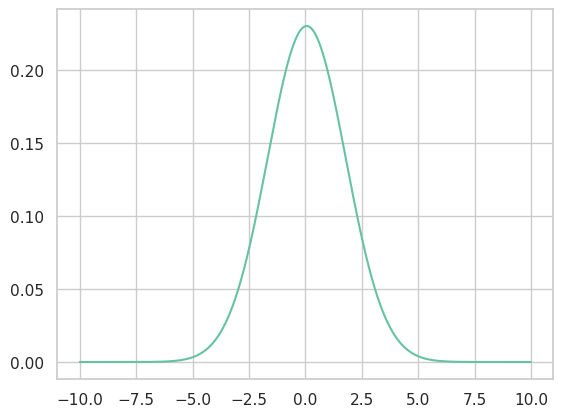

Distribution on encrypted data:


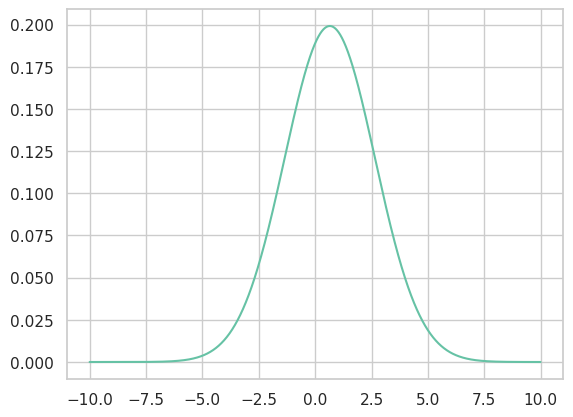

In [27]:
# Polynomial 1, 20 pca

# model instance
set_seed()

epochs = 100
model = LR(n_features)

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
data = model.lr(X_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(model)
eelr.encrypt(ctx_train)
encrypted_out_distribution(eelr, enc_x_train)

Distribution on plain data:


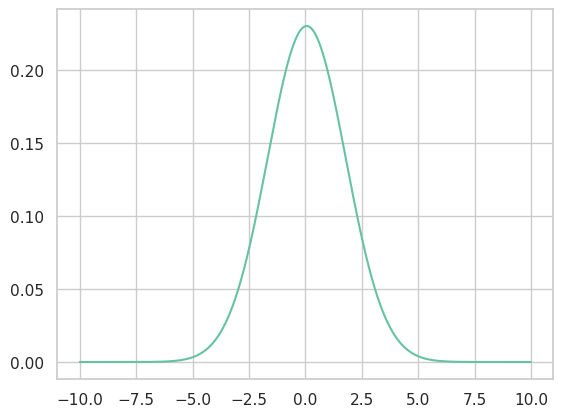

Distribution on encrypted data:


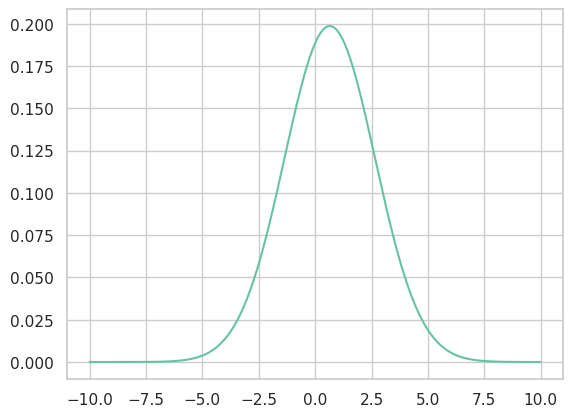

In [29]:
# Polynomial 2, 20 pca

# model instance
set_seed()

epochs = 100
model = LR(n_features)

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
data = model.lr(X_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(model)
eelr.encrypt(ctx_train)
encrypted_out_distribution(eelr, enc_x_train)

# train encrypted model on plain data. Use torch.softmax

In [31]:
def train_enc_model_non_enc_data(learning_rate=1e-5, l1=0.005, epochs=200, approx_sigmoid=False):
    set_seed()

    # a model instance
    lr = LR(n_features)
    eelr = EncryptedLR(lr, is_encrypted=False, approx_sigmoid=approx_sigmoid, learning_rate=learning_rate, l1=l1)

    # eelr.encrypt(ctx_train)

    times = []
    test_loss_hist = []
    train_loss_hist = []
    train_f1_hist = []
    test_f1_hist = []
    train_pr_hist = []
    test_pr_hist = []
    gradient_w = []
    gradient_b = []

    for epoch in tqdm.tqdm(range(epochs)):

        t_start = time()
        for enc_x, enc_y in zip(X_train, y_train):
            enc_out = eelr.forward(enc_x)
            eelr.backward(enc_x, enc_out, enc_y)

        gradient_w.append(eelr._delta_w.abs().mean())
        gradient_b.append(eelr._delta_b.abs().mean())

        eelr.update_parameters()
        t_end = time()
        times.append(t_end - t_start)

        enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
        enc_precision_test = eelr.plain_precision(X_test, y_test)
        enc_f1score_test = eelr.plain_f1score(X_test, y_test)
        test_f1_hist.append(enc_f1score_test.item())
        
        test_pr_hist.append(enc_precision_test.item())
        
        enc_auc_test = eelr.plain_auroc(X_test, y_test)
        enc_loss_test = eelr.bce_loss(X_test, y_test)
        test_loss_hist.append(enc_loss_test.item())
        #print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")

        enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
        enc_precision_train = eelr.plain_precision(X_train, y_train)
        enc_f1score_train = eelr.plain_f1score(X_train, y_train)
        train_f1_hist.append(enc_f1score_train.item())
        train_pr_hist.append(enc_precision_train.item())
        enc_auc_train = eelr.plain_auroc(X_train, y_train)
        enc_loss_train = eelr.bce_loss(X_train, y_train)
        train_loss_hist.append(enc_loss_train.item())
        
    print('Results')
    print(f'f1-score test set: {enc_f1score_test:.4f}')
    print(f'precision test set: {enc_precision_test:.4f}')

    plt.figure(figsize=(3, 2)) 
    plt.title('Test loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Test f1')
    plt.plot(np.arange(len(test_f1_hist)), test_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train f1')
    plt.plot(np.arange(len(train_f1_hist)), train_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()
    
    plt.figure(figsize=(3, 2)) 
    plt.title('Test precision')
    plt.plot(np.arange(len(test_pr_hist)), test_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train precision')
    plt.plot(np.arange(len(train_pr_hist)), train_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Weight gradient')
    plt.plot(np.arange(len(gradient_w)), gradient_w)
    plt.xlabel('Epoch')
    plt.ylabel('grad')
    plt.show()

In [36]:
learning_rate = 1e-5
# learning rate
print(format(learning_rate, 'f'))

0.000010


In [40]:
learning_rate = 1e-3
# learning rate
print(format(learning_rate, 'f'))

0.001000


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_14909/251211232.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_14909/251211232.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Results
f1-score test set: 0.8665
precision test set: 0.8731


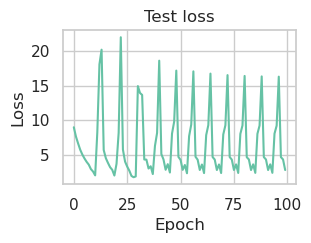

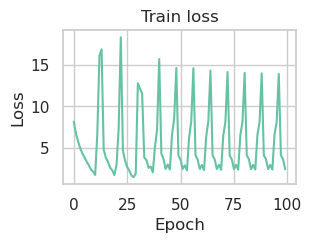

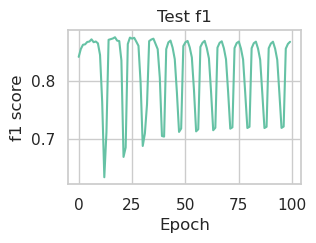

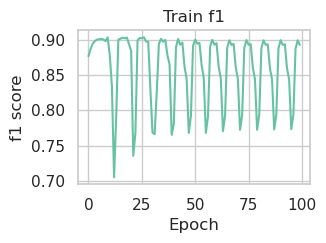

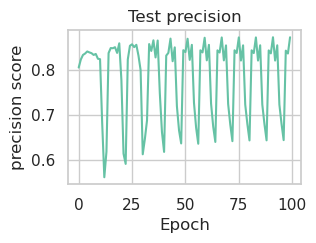

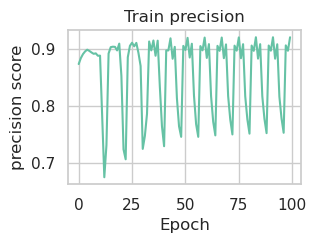

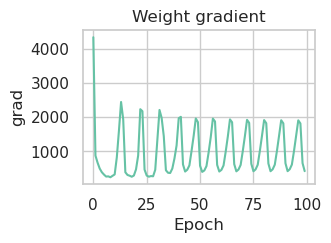

In [32]:
# 20 features and learning rate 0.1

train_enc_model_non_enc_data(learning_rate=1e-3, l1=0.05, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_14909/251211232.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_14909/251211232.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Results
f1-score test set: 0.8732
precision test set: 0.8570


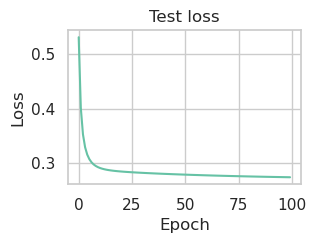

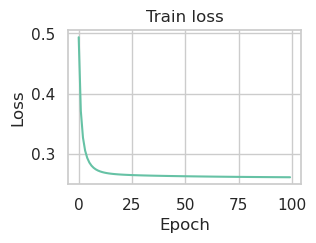

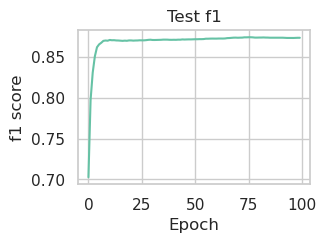

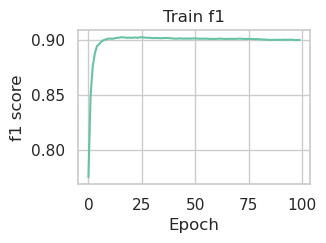

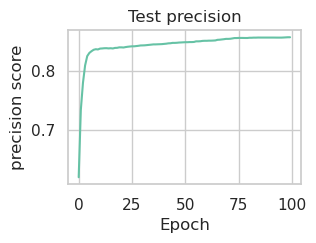

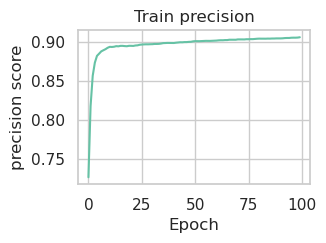

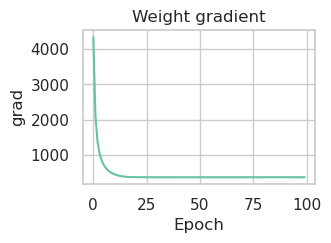

In [33]:
# with 20 features and learning rate 0.001

train_enc_model_non_enc_data(learning_rate=1e-5, l1=0.05, epochs=100)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_14909/251211232.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_14909/251211232.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Results
f1-score test set: 0.8734
precision test set: 0.8539


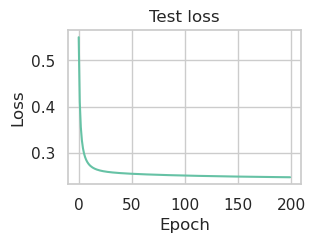

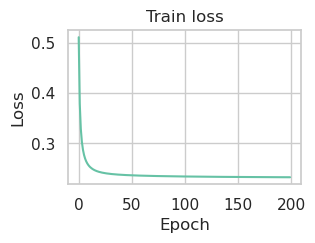

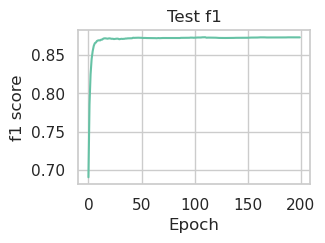

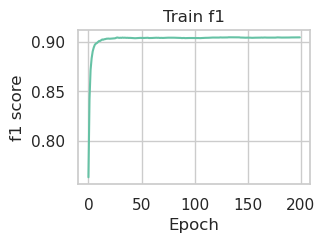

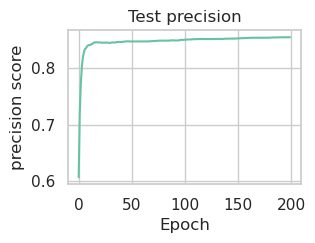

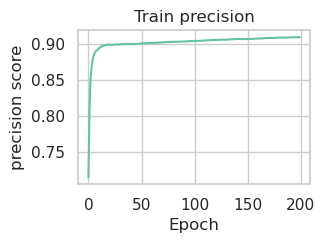

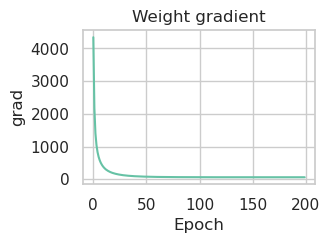

In [34]:
# with 20 features and learning rate 0.00001

train_enc_model_non_enc_data(learning_rate=1e-5, l1=0.005, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_14909/251211232.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_14909/251211232.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Results
f1-score test set: 0.8733
precision test set: 0.8521


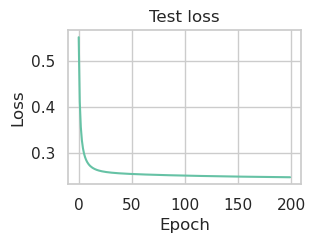

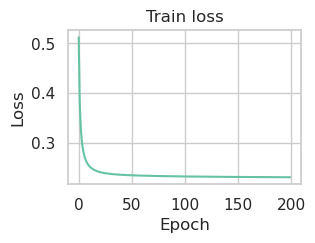

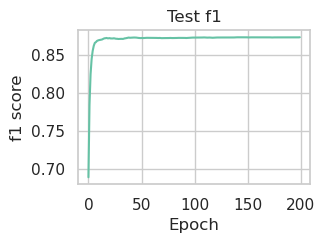

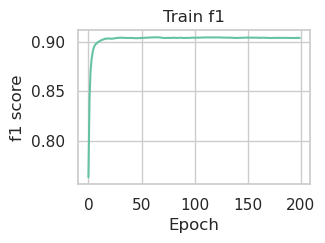

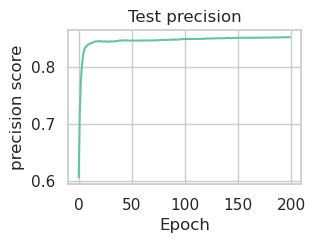

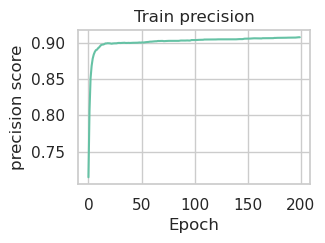

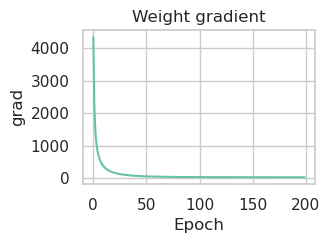

In [35]:
# with 20 features and learning rate 0.00001  and reg 0.002
train_enc_model_non_enc_data(learning_rate=1e-5, l1=0.002, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_14909/251211232.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_14909/251211232.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_14909/251211232.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Results
f1-score test set: 0.8697
precision test set: 0.8399


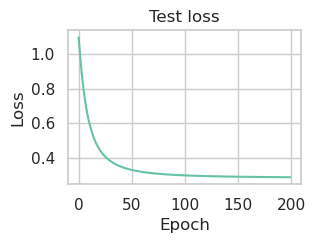

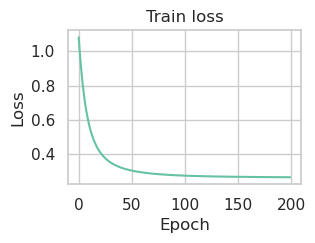

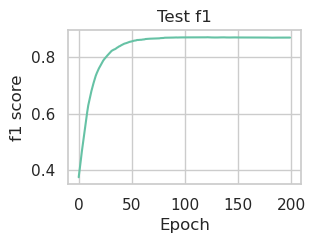

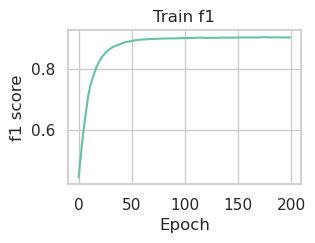

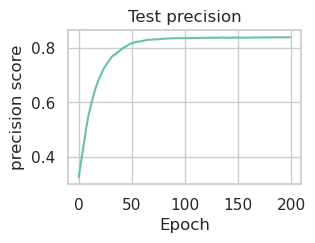

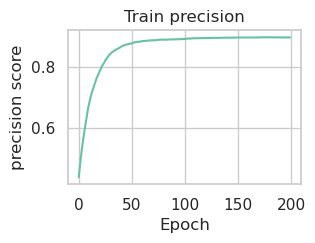

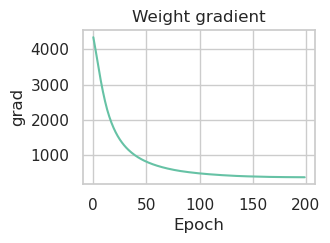

In [36]:
train_enc_model_non_enc_data(learning_rate=1e-6, l1=0.005, epochs=200)

### Training on encrypted data

In [19]:
def train_enc_model_enc_data(learning_rate=1e-5, l1=0.005, epochs=100, approx_sigmoid=True):
    set_seed()

    # a model instance. change to True for encrypted data
    lr = LR(n_features)
    eelr = EncryptedLR(lr, is_encrypted=True, approx_sigmoid=approx_sigmoid, learning_rate=learning_rate, l1=l1)

    
    times = []
    test_loss_hist = []
    train_loss_hist = []
    train_f1_hist = []
    test_f1_hist = []
    train_pr_hist = []
    test_pr_hist = []
    gradient_w = []
    gradient_b = []

    for epoch in tqdm.tqdm(range(epochs)):
        eelr.encrypt(ctx_train)

        t_start = time()
        for enc_x, enc_y in zip(enc_x_train, enc_y_train):
            enc_out = eelr.forward(enc_x)
            eelr.backward(enc_x, enc_out, enc_y)

#        gradient_w.append(eelr._delta_w.abs().mean())
#        gradient_b.append(eelr._delta_b.abs().mean())

        eelr.update_parameters()
        t_end = time()
        times.append(t_end - t_start)
        
        eelr.decrypt()

        enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
        enc_precision_test = eelr.plain_precision(X_test, y_test)
        enc_f1score_test = eelr.plain_f1score(X_test, y_test)
        test_f1_hist.append(enc_f1score_test.item())
        
        test_pr_hist.append(enc_precision_test.item())
        
        enc_auc_test = eelr.plain_auroc(X_test, y_test)
        enc_loss_test = eelr.bce_loss(X_test, y_test)
        test_loss_hist.append(enc_loss_test.item())
        print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")

        enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
        enc_precision_train = eelr.plain_precision(X_train, y_train)
        enc_f1score_train = eelr.plain_f1score(X_train, y_train)
        train_f1_hist.append(enc_f1score_train.item())
        train_pr_hist.append(enc_precision_train.item())
        enc_auc_train = eelr.plain_auroc(X_train, y_train)
        enc_loss_train = eelr.bce_loss(X_train, y_train)
        train_loss_hist.append(enc_loss_train.item())
        
        
    print('Results')
    print(f'loss test set: {enc_loss_test:.4f}')
    print(f'f1-score test set: {enc_f1score_test:.4f}')
    print(f'accuracy test set: {enc_accuracy_test:.4f}')
    print(f'precision test set: {enc_precision_test:.4f}')
    print(f'AUC score test set: {enc_auc_test:.4f}')

    plt.figure(figsize=(3, 2)) 
    plt.title('Test loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Test f1')
    sns.lineplot(np.arange(len(test_f1_hist)), test_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train f1')
    plt.plot(np.arange(len(train_f1_hist)), train_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()
    
    plt.figure(figsize=(3, 2)) 
    plt.title('Test precision')
    plt.plot(np.arange(len(test_pr_hist)), test_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train precision')
    plt.plot(np.arange(len(train_pr_hist)), train_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Weight gradient')
    plt.plot(np.arange(len(gradient_w)), gradient_w)
    plt.xlabel('Epoch')
    plt.ylabel('grad')
    plt.show()

In [38]:
train_enc_model_enc_data(learning_rate=1e-5, l1=0.005, epochs=50)

  5%|▌         | 1/20 [25:06<7:57:03, 1506.48s/it]

Test Loss at epoch #1 is 0.35015228390693665|Test Accuracy at epoch #1 is 0.8798999786376953|Precision is 0.8158905506134033|F1-score is 0.8498562574386597|AUC is 0.9452563524246216


 10%|█         | 2/20 [50:08<7:31:11, 1503.96s/it]

Test Loss at epoch #2 is 6.696793556213379|Test Accuracy at epoch #2 is 0.8582000136375427|Precision is 0.8051553964614868|F1-score is 0.8179717659950256|AUC is 0.9091272950172424


 15%|█▌        | 3/20 [1:15:11<7:05:58, 1503.46s/it]

Test Loss at epoch #3 is 16.384981155395508|Test Accuracy at epoch #3 is 0.8360999822616577|Precision is 0.7718037366867065|F1-score is 0.7917143106460571|AUC is 0.8317638039588928


 20%|██        | 4/20 [1:40:13<6:40:47, 1502.98s/it]

Test Loss at epoch #4 is 61.66999816894531|Test Accuracy at epoch #4 is 0.3833000063896179|Precision is 0.3833000063896179|F1-score is 0.5541820526123047|AUC is 0.5


 25%|██▌       | 5/20 [2:05:15<6:15:38, 1502.56s/it]

Test Loss at epoch #5 is 61.66999816894531|Test Accuracy at epoch #5 is 0.3833000063896179|Precision is 0.3833000063896179|F1-score is 0.5541820526123047|AUC is 0.5


 30%|███       | 6/20 [2:30:17<5:50:33, 1502.42s/it]

Test Loss at epoch #6 is 38.33000183105469|Test Accuracy at epoch #6 is 0.6166999936103821|Precision is 0.0|F1-score is 0.0|AUC is 0.5


 30%|███       | 6/20 [2:31:38<5:53:50, 1516.47s/it]


KeyboardInterrupt: 

  5%|▌         | 1/20 [25:20<8:01:30, 1520.54s/it]

Test Loss at epoch #1 is 0.8725572228431702|Test Accuracy at epoch #1 is 0.5209000110626221|Precision is 0.4090736508369446|F1-score is 0.47357434034347534|AUC is 0.543255090713501


 10%|█         | 2/20 [50:29<7:34:04, 1513.59s/it]

Test Loss at epoch #2 is 0.6804652214050293|Test Accuracy at epoch #2 is 0.6244000196456909|Precision is 0.5073263645172119|F1-score is 0.5867077708244324|AUC is 0.6968740224838257


 15%|█▌        | 3/20 [1:15:37<7:08:10, 1511.23s/it]

Test Loss at epoch #3 is 0.5699240565299988|Test Accuracy at epoch #3 is 0.7032999992370605|Precision is 0.5838172435760498|F1-score is 0.6702967286109924|AUC is 0.7979193329811096


 20%|██        | 4/20 [1:40:46<6:42:43, 1510.25s/it]

Test Loss at epoch #4 is 0.5058019757270813|Test Accuracy at epoch #4 is 0.7493000030517578|Precision is 0.6312351822853088|F1-score is 0.7178390622138977|AUC is 0.8547446727752686


 25%|██▌       | 5/20 [2:05:55<6:17:24, 1509.67s/it]

Test Loss at epoch #5 is 0.46470990777015686|Test Accuracy at epoch #5 is 0.7846999764442444|Precision is 0.6710794568061829|F1-score is 0.7537458539009094|AUC is 0.8878534436225891


 30%|███       | 6/20 [2:32:19<5:58:10, 1535.01s/it]

Test Loss at epoch #6 is 0.4384388327598572|Test Accuracy at epoch #6 is 0.8055999875068665|Precision is 0.6963209509849548|F1-score is 0.7751041054725647|AUC is 0.9070397615432739


 35%|███▌      | 7/20 [2:59:45<5:40:28, 1571.44s/it]

Test Loss at epoch #7 is 0.4200282096862793|Test Accuracy at epoch #7 is 0.8233000040054321|Precision is 0.7186706066131592|F1-score is 0.7935023903846741|AUC is 0.9195435643196106


 40%|████      | 8/20 [3:27:22<5:19:43, 1598.62s/it]

Test Loss at epoch #8 is 0.4085332453250885|Test Accuracy at epoch #8 is 0.8355000019073486|Precision is 0.7343615889549255|F1-score is 0.80649334192276|AUC is 0.9271179437637329


 45%|████▌     | 9/20 [3:55:00<4:56:27, 1617.06s/it]

Test Loss at epoch #9 is 0.39934587478637695|Test Accuracy at epoch #9 is 0.8458999991416931|Precision is 0.7473025321960449|F1-score is 0.8179993033409119|AUC is 0.9332263469696045


 50%|█████     | 10/20 [4:22:38<4:31:37, 1629.73s/it]

Test Loss at epoch #10 is 0.3919774293899536|Test Accuracy at epoch #10 is 0.8507000207901001|Precision is 0.7534661889076233|F1-score is 0.8232926726341248|AUC is 0.9374520778656006


 55%|█████▌    | 11/20 [4:50:16<4:05:46, 1638.51s/it]

Test Loss at epoch #11 is 0.38727521896362305|Test Accuracy at epoch #11 is 0.8553000092506409|Precision is 0.7588975429534912|F1-score is 0.8285748362541199|AUC is 0.9408106207847595


 60%|██████    | 12/20 [5:17:55<3:39:17, 1644.68s/it]

Test Loss at epoch #12 is 0.38285496830940247|Test Accuracy at epoch #12 is 0.8583999872207642|Precision is 0.7627745270729065|F1-score is 0.8320683240890503|AUC is 0.9433917999267578


 65%|██████▌   | 13/20 [5:45:35<3:12:24, 1649.26s/it]

Test Loss at epoch #13 is 0.3805587589740753|Test Accuracy at epoch #13 is 0.8615000247955322|Precision is 0.7664344906806946|F1-score is 0.8356473445892334|AUC is 0.9453511834144592


 70%|███████   | 14/20 [6:13:15<2:45:15, 1652.55s/it]

Test Loss at epoch #14 is 0.3776035010814667|Test Accuracy at epoch #14 is 0.8655999898910522|Precision is 0.7713102102279663|F1-score is 0.840380072593689|AUC is 0.9472268223762512


 75%|███████▌  | 15/20 [6:40:55<2:17:54, 1654.91s/it]

Test Loss at epoch #15 is 0.3747541308403015|Test Accuracy at epoch #15 is 0.8669999837875366|Precision is 0.7722427845001221|F1-score is 0.8422301411628723|AUC is 0.9489843249320984


 80%|████████  | 16/20 [7:08:36<1:50:26, 1656.55s/it]

Test Loss at epoch #16 is 0.37333542108535767|Test Accuracy at epoch #16 is 0.8680999875068665|Precision is 0.7734987139701843|F1-score is 0.8435164093971252|AUC is 0.9499943852424622


 85%|████████▌ | 17/20 [7:35:56<1:22:35, 1651.73s/it]

Test Loss at epoch #17 is 0.373409241437912|Test Accuracy at epoch #17 is 0.8676000237464905|Precision is 0.7724213004112244|F1-score is 0.8430907726287842|AUC is 0.9508553743362427


 90%|█████████ | 18/20 [8:03:00<54:46, 1643.31s/it]  

Test Loss at epoch #18 is 0.3726409077644348|Test Accuracy at epoch #18 is 0.8691999912261963|Precision is 0.7739205956459045|F1-score is 0.845060408115387|AUC is 0.9517855048179626


 95%|█████████▌| 19/20 [8:28:44<26:53, 1613.50s/it]

Test Loss at epoch #19 is 0.37105947732925415|Test Accuracy at epoch #19 is 0.869700014591217|Precision is 0.7745225429534912|F1-score is 0.845634400844574|AUC is 0.9525194764137268


100%|██████████| 20/20 [8:53:30<00:00, 1600.50s/it]

Test Loss at epoch #20 is 0.37082740664482117|Test Accuracy at epoch #20 is 0.8695999979972839|Precision is 0.7734054327011108|F1-score is 0.8458264470100403|AUC is 0.9531465768814087
Results
loss test set: 0.3708
f1-score test set: 0.8458
accuracy test set: 0.8696
precision test set: 0.7734
AUC score test set: 0.9531


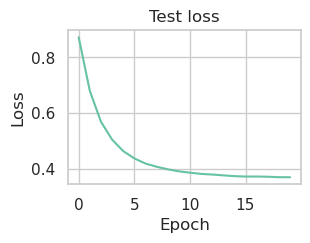

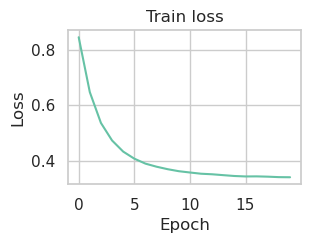

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


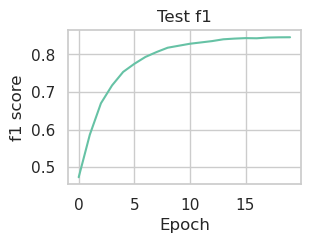

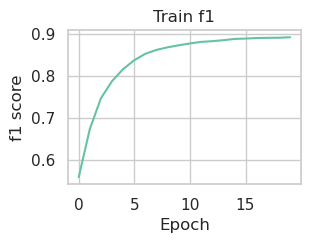

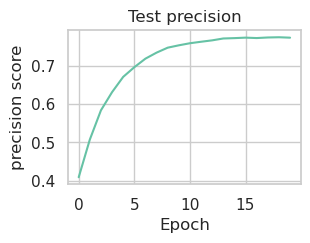

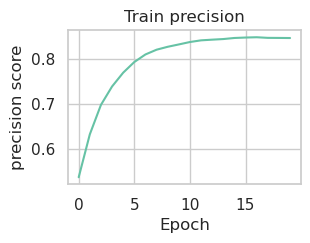

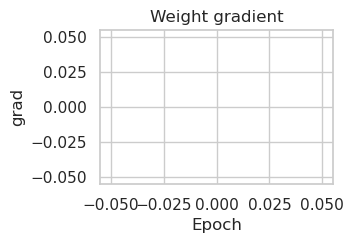

In [17]:
train_enc_model_enc_data(learning_rate=1e-6, l1=0.005, epochs=20)

  2%|▏         | 1/50 [23:15<18:59:53, 1395.78s/it]

Test Loss at epoch #1 is 1.190917730331421|Test Accuracy at epoch #1 is 0.40119999647140503|Precision is 0.2955020070075989|F1-score is 0.3421226143836975|AUC is 0.36230117082595825


  4%|▍         | 2/50 [46:28<18:35:24, 1394.25s/it]

Test Loss at epoch #2 is 1.184448480606079|Test Accuracy at epoch #2 is 0.40209999680519104|Precision is 0.2960851490497589|F1-score is 0.3426058292388916|AUC is 0.3632524609565735


  6%|▌         | 3/50 [1:09:44<18:12:38, 1394.87s/it]

Test Loss at epoch #3 is 1.1772010326385498|Test Accuracy at epoch #3 is 0.4027999937534332|Precision is 0.29740482568740845|F1-score is 0.34460052847862244|AUC is 0.36425209045410156


  8%|▊         | 4/50 [1:32:58<17:49:15, 1394.68s/it]

Test Loss at epoch #4 is 1.1753228902816772|Test Accuracy at epoch #4 is 0.4027999937534332|Precision is 0.2968660891056061|F1-score is 0.34359198808670044|AUC is 0.363633394241333


 10%|█         | 5/50 [1:56:13<17:25:55, 1394.56s/it]

Test Loss at epoch #5 is 1.1707954406738281|Test Accuracy at epoch #5 is 0.4036000072956085|Precision is 0.29754891991615295|F1-score is 0.3443271815776825|AUC is 0.36464840173721313


 12%|█▏        | 6/50 [2:19:26<17:02:27, 1394.26s/it]

Test Loss at epoch #6 is 1.169833779335022|Test Accuracy at epoch #6 is 0.40299999713897705|Precision is 0.29705601930618286|F1-score is 0.34381183981895447|AUC is 0.36339065432548523


 14%|█▍        | 7/50 [2:42:40<16:38:59, 1393.94s/it]

Test Loss at epoch #7 is 1.1650025844573975|Test Accuracy at epoch #7 is 0.4027999937534332|Precision is 0.2970203161239624|F1-score is 0.34388047456741333|AUC is 0.3634944260120392


 16%|█▌        | 8/50 [3:05:53<16:15:38, 1393.77s/it]

Test Loss at epoch #8 is 1.155414342880249|Test Accuracy at epoch #8 is 0.4032999873161316|Precision is 0.2974563539028168|F1-score is 0.34435775876045227|AUC is 0.36578717827796936


 18%|█▊        | 9/50 [3:29:06<15:52:12, 1393.49s/it]

Test Loss at epoch #9 is 1.1485354900360107|Test Accuracy at epoch #9 is 0.4041000008583069|Precision is 0.29852160811424255|F1-score is 0.3458118438720703|AUC is 0.3676495850086212


 20%|██        | 10/50 [3:52:18<15:28:37, 1392.93s/it]

Test Loss at epoch #10 is 1.1477760076522827|Test Accuracy at epoch #10 is 0.4025000035762787|Precision is 0.2971591055393219|F1-score is 0.34434324502944946|AUC is 0.3655543625354767


 22%|██▏       | 11/50 [4:15:29<15:05:06, 1392.47s/it]

Test Loss at epoch #11 is 1.1456830501556396|Test Accuracy at epoch #11 is 0.4027999937534332|Precision is 0.2976348102092743|F1-score is 0.3450317978858948|AUC is 0.3662659525871277


 24%|██▍       | 12/50 [4:38:41<14:41:51, 1392.41s/it]

Test Loss at epoch #12 is 1.1491751670837402|Test Accuracy at epoch #12 is 0.40059998631477356|Precision is 0.295939564704895|F1-score is 0.3433391749858856|AUC is 0.3637959957122803


 26%|██▌       | 13/50 [5:01:56<14:19:04, 1393.10s/it]

Test Loss at epoch #13 is 1.1449499130249023|Test Accuracy at epoch #13 is 0.4000000059604645|Precision is 0.2956046164035797|F1-score is 0.34311363101005554|AUC is 0.3628309965133667


 28%|██▊       | 14/50 [5:25:09<13:55:47, 1392.99s/it]

Test Loss at epoch #14 is 1.1364212036132812|Test Accuracy at epoch #14 is 0.40310001373291016|Precision is 0.298338383436203|F1-score is 0.34614962339401245|AUC is 0.3663676679134369


 30%|███       | 15/50 [5:48:21<13:32:28, 1392.81s/it]

Test Loss at epoch #15 is 1.1290459632873535|Test Accuracy at epoch #15 is 0.4065999984741211|Precision is 0.3013802170753479|F1-score is 0.34948477149009705|AUC is 0.3697781264781952


 32%|███▏      | 16/50 [6:11:35<13:09:26, 1393.14s/it]

Test Loss at epoch #16 is 1.1243019104003906|Test Accuracy at epoch #16 is 0.4065000116825104|Precision is 0.3008715510368347|F1-score is 0.34858962893486023|AUC is 0.37001460790634155


 34%|███▍      | 17/50 [6:34:49<12:46:19, 1393.32s/it]

Test Loss at epoch #17 is 1.1180671453475952|Test Accuracy at epoch #17 is 0.4066999852657318|Precision is 0.30151230096817017|F1-score is 0.34966567158699036|AUC is 0.37150996923446655


 36%|███▌      | 18/50 [6:58:03<12:23:10, 1393.44s/it]

Test Loss at epoch #18 is 1.1096822023391724|Test Accuracy at epoch #18 is 0.40939998626708984|Precision is 0.30387890338897705|F1-score is 0.352270245552063|AUC is 0.3750993311405182


 38%|███▊      | 19/50 [7:21:17<12:00:04, 1393.69s/it]

Test Loss at epoch #19 is 1.1036827564239502|Test Accuracy at epoch #19 is 0.41029998660087585|Precision is 0.30454546213150024|F1-score is 0.35290244221687317|AUC is 0.3757697641849518


 40%|████      | 20/50 [7:44:30<11:36:44, 1393.49s/it]

Test Loss at epoch #20 is 1.1004383563995361|Test Accuracy at epoch #20 is 0.41260001063346863|Precision is 0.3071253001689911|F1-score is 0.3562034070491791|AUC is 0.377801775932312


 42%|████▏     | 21/50 [8:07:44<11:13:36, 1393.69s/it]

Test Loss at epoch #21 is 1.1007734537124634|Test Accuracy at epoch #21 is 0.4124000072479248|Precision is 0.3072277903556824|F1-score is 0.35654839873313904|AUC is 0.3786773085594177


 44%|████▍     | 22/50 [8:30:58<10:50:26, 1393.81s/it]

Test Loss at epoch #22 is 1.0992815494537354|Test Accuracy at epoch #22 is 0.41100001335144043|Precision is 0.30605319142341614|F1-score is 0.355297714471817|AUC is 0.3764224648475647


 46%|████▌     | 23/50 [8:54:12<10:27:11, 1393.77s/it]

Test Loss at epoch #23 is 1.0923957824707031|Test Accuracy at epoch #23 is 0.4108000099658966|Precision is 0.30637577176094055|F1-score is 0.356065571308136|AUC is 0.37759047746658325


 48%|████▊     | 24/50 [9:17:24<10:03:48, 1393.40s/it]

Test Loss at epoch #24 is 1.086533546447754|Test Accuracy at epoch #24 is 0.4099999964237213|Precision is 0.3059883713722229|F1-score is 0.35589519143104553|AUC is 0.3775031566619873


 50%|█████     | 25/50 [9:40:38<9:40:38, 1393.53s/it] 

Test Loss at epoch #25 is 1.0806193351745605|Test Accuracy at epoch #25 is 0.40939998626708984|Precision is 0.30564409494400024|F1-score is 0.3556622266769409|AUC is 0.3770933747291565


 52%|█████▏    | 26/50 [10:03:52<9:17:29, 1393.74s/it]

Test Loss at epoch #26 is 1.0768929719924927|Test Accuracy at epoch #26 is 0.40880000591278076|Precision is 0.30530062317848206|F1-score is 0.3554295599460602|AUC is 0.377860963344574


 54%|█████▍    | 27/50 [10:27:03<8:53:57, 1392.92s/it]

Test Loss at epoch #27 is 1.0748437643051147|Test Accuracy at epoch #27 is 0.40869998931884766|Precision is 0.3053892254829407|F1-score is 0.35567179322242737|AUC is 0.37690141797065735


 56%|█████▌    | 28/50 [10:50:15<8:30:38, 1392.66s/it]

Test Loss at epoch #28 is 1.0719560384750366|Test Accuracy at epoch #28 is 0.4068000018596649|Precision is 0.30386844277381897|F1-score is 0.35409408807754517|AUC is 0.37401053309440613


 58%|█████▊    | 29/50 [11:13:29<8:07:32, 1392.99s/it]

Test Loss at epoch #29 is 1.0700467824935913|Test Accuracy at epoch #29 is 0.4065000116825104|Precision is 0.30333083868026733|F1-score is 0.35327449440956116|AUC is 0.3733848035335541


 60%|██████    | 30/50 [11:36:42<7:44:19, 1392.98s/it]

Test Loss at epoch #30 is 1.0666966438293457|Test Accuracy at epoch #30 is 0.4077000021934509|Precision is 0.30379271507263184|F1-score is 0.353313684463501|AUC is 0.37384241819381714


 62%|██████▏   | 31/50 [11:59:51<7:20:42, 1391.70s/it]

Test Loss at epoch #31 is 1.0639731884002686|Test Accuracy at epoch #31 is 0.40560001134872437|Precision is 0.30215558409690857|F1-score is 0.3516579270362854|AUC is 0.3720361590385437


 64%|██████▍   | 32/50 [12:23:00<6:57:14, 1390.81s/it]

Test Loss at epoch #32 is 1.0574144124984741|Test Accuracy at epoch #32 is 0.40630000829696655|Precision is 0.303511381149292|F1-score is 0.3537607491016388|AUC is 0.3731110692024231


 66%|██████▌   | 33/50 [12:46:09<6:33:55, 1390.29s/it]

Test Loss at epoch #33 is 1.050014853477478|Test Accuracy at epoch #33 is 0.40799999237060547|Precision is 0.3052808344364166|F1-score is 0.35596171021461487|AUC is 0.3752269744873047


 68%|██████▊   | 34/50 [13:09:17<6:10:36, 1389.75s/it]

Test Loss at epoch #34 is 1.046423077583313|Test Accuracy at epoch #34 is 0.4072999954223633|Precision is 0.30451828241348267|F1-score is 0.3549896478652954|AUC is 0.3742533028125763


 70%|███████   | 35/50 [13:32:29<5:47:34, 1390.32s/it]

Test Loss at epoch #35 is 1.0500962734222412|Test Accuracy at epoch #35 is 0.4050999879837036|Precision is 0.3030528724193573|F1-score is 0.3537208139896393|AUC is 0.3716994524002075


 72%|███████▏  | 36/50 [13:55:37<5:24:14, 1389.59s/it]

Test Loss at epoch #36 is 1.0451080799102783|Test Accuracy at epoch #36 is 0.4059999883174896|Precision is 0.3032679855823517|F1-score is 0.35350456833839417|AUC is 0.3728599548339844


 74%|███████▍  | 37/50 [14:18:46<5:01:04, 1389.61s/it]

Test Loss at epoch #37 is 1.034988522529602|Test Accuracy at epoch #37 is 0.40860000252723694|Precision is 0.30525922775268555|F1-score is 0.35549259185791016|AUC is 0.37589529156684875


 76%|███████▌  | 38/50 [14:41:54<4:37:49, 1389.13s/it]

Test Loss at epoch #38 is 1.0325201749801636|Test Accuracy at epoch #38 is 0.40700000524520874|Precision is 0.3042747676372528|F1-score is 0.354733407497406|AUC is 0.37475472688674927


 78%|███████▊  | 39/50 [15:05:02<4:14:34, 1388.55s/it]

Test Loss at epoch #39 is 1.0281721353530884|Test Accuracy at epoch #39 is 0.40959998965263367|Precision is 0.30648475885391235|F1-score is 0.3571428656578064|AUC is 0.37701717019081116


 80%|████████  | 40/50 [15:28:11<3:51:27, 1388.75s/it]

Test Loss at epoch #40 is 1.0207884311676025|Test Accuracy at epoch #40 is 0.4117000102996826|Precision is 0.30869728326797485|F1-score is 0.3599173128604889|AUC is 0.3806324899196625


 82%|████████▏ | 41/50 [15:51:19<3:28:16, 1388.47s/it]

Test Loss at epoch #41 is 1.018872618675232|Test Accuracy at epoch #41 is 0.4115999937057495|Precision is 0.30835357308387756|F1-score is 0.3593205511569977|AUC is 0.3800566792488098


 84%|████████▍ | 42/50 [16:14:27<3:05:08, 1388.56s/it]

Test Loss at epoch #42 is 1.019471526145935|Test Accuracy at epoch #42 is 0.4092999994754791|Precision is 0.3059506118297577|F1-score is 0.35632559657096863|AUC is 0.3754592537879944


 86%|████████▌ | 43/50 [16:37:37<2:42:01, 1388.77s/it]

Test Loss at epoch #43 is 1.0217891931533813|Test Accuracy at epoch #43 is 0.4058000147342682|Precision is 0.3030812442302704|F1-score is 0.35328689217567444|AUC is 0.37188389897346497


 88%|████████▊ | 44/50 [17:00:46<2:18:54, 1389.03s/it]

Test Loss at epoch #44 is 1.0184173583984375|Test Accuracy at epoch #44 is 0.4047999978065491|Precision is 0.303103506565094|F1-score is 0.3540264666080475|AUC is 0.37195491790771484


 90%|█████████ | 45/50 [17:23:56<1:55:45, 1389.11s/it]

Test Loss at epoch #45 is 1.0185316801071167|Test Accuracy at epoch #45 is 0.40400001406669617|Precision is 0.3020658791065216|F1-score is 0.35259613394737244|AUC is 0.3704146146774292


 92%|█████████▏| 46/50 [17:47:05<1:32:36, 1389.24s/it]

Test Loss at epoch #46 is 1.020302414894104|Test Accuracy at epoch #46 is 0.4016000032424927|Precision is 0.29953402280807495|F1-score is 0.3494237959384918|AUC is 0.3670990467071533


 94%|█████████▍| 47/50 [18:10:15<1:09:28, 1389.51s/it]

Test Loss at epoch #47 is 1.0175446271896362|Test Accuracy at epoch #47 is 0.40209999680519104|Precision is 0.30055761337280273|F1-score is 0.3510257303714752|AUC is 0.36765795946121216


 96%|█████████▌| 48/50 [18:33:25<46:18, 1389.44s/it]  

Test Loss at epoch #48 is 1.014221429824829|Test Accuracy at epoch #48 is 0.39959999918937683|Precision is 0.2981967031955719|F1-score is 0.3482414186000824|AUC is 0.36564722657203674


 98%|█████████▊| 49/50 [18:56:33<23:09, 1389.20s/it]

Test Loss at epoch #49 is 1.0140705108642578|Test Accuracy at epoch #49 is 0.400299996137619|Precision is 0.2990341782569885|F1-score is 0.34935444593429565|AUC is 0.36361098289489746


100%|██████████| 50/50 [19:19:44<00:00, 1391.68s/it]

Test Loss at epoch #50 is 1.0065348148345947|Test Accuracy at epoch #50 is 0.39989998936653137|Precision is 0.2985878884792328|F1-score is 0.34877917170524597|AUC is 0.36486881971359253
Results
loss test set: 1.0065
f1-score test set: 0.3488
accuracy test set: 0.3999
precision test set: 0.2986
AUC score test set: 0.3649


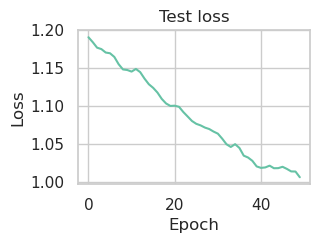

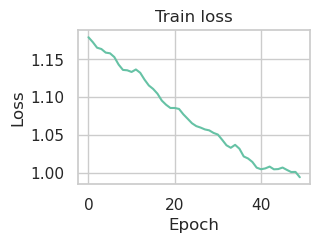

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


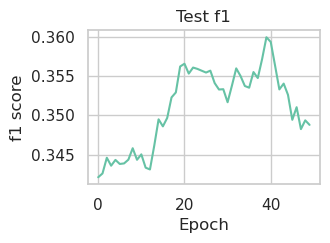

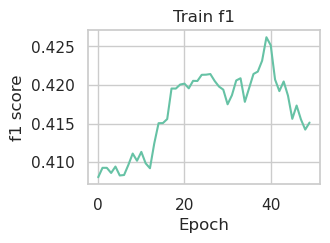

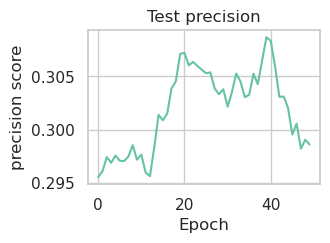

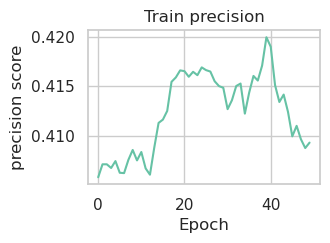

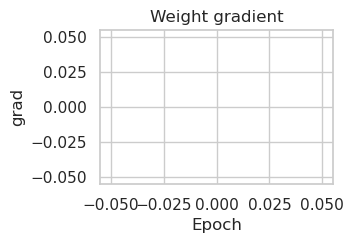

In [ ]:
train_enc_model_enc_data(learning_rate=1e-7, l1=0.005, epochs=50)

  5%|▌         | 1/20 [24:55<7:53:40, 1495.84s/it]

Test Loss at epoch #1 is 1.181378960609436|Test Accuracy at epoch #1 is 0.4036000072956085|Precision is 0.29739493131637573|F1-score is 0.344038724899292|AUC is 0.36524754762649536


 10%|█         | 2/20 [49:59<7:30:06, 1500.36s/it]

Test Loss at epoch #2 is 1.180893898010254|Test Accuracy at epoch #2 is 0.4034999907016754|Precision is 0.29756930470466614|F1-score is 0.344433456659317|AUC is 0.3653036952018738


 15%|█▌        | 3/20 [1:14:58<7:04:53, 1499.64s/it]

Test Loss at epoch #3 is 1.176880955696106|Test Accuracy at epoch #3 is 0.4016999900341034|Precision is 0.2956273853778839|F1-score is 0.3420213460922241|AUC is 0.3631209135055542


 20%|██        | 4/20 [1:39:56<6:39:43, 1498.95s/it]

Test Loss at epoch #4 is 1.1712582111358643|Test Accuracy at epoch #4 is 0.40290001034736633|Precision is 0.296922504901886|F1-score is 0.34362977743148804|AUC is 0.3640546202659607


 25%|██▌       | 5/20 [2:04:39<6:13:21, 1493.46s/it]

Test Loss at epoch #5 is 1.1649086475372314|Test Accuracy at epoch #5 is 0.4027999937534332|Precision is 0.29694321751594543|F1-score is 0.3437362611293793|AUC is 0.36475640535354614


 30%|███       | 6/20 [2:29:22<5:47:35, 1489.70s/it]

Test Loss at epoch #6 is 1.168968915939331|Test Accuracy at epoch #6 is 0.40149998664855957|Precision is 0.2956703305244446|F1-score is 0.34223541617393494|AUC is 0.3617333173751831


 35%|███▌      | 7/20 [2:54:48<5:25:21, 1501.68s/it]

Test Loss at epoch #7 is 1.1696468591690063|Test Accuracy at epoch #7 is 0.399399995803833|Precision is 0.2938721179962158|F1-score is 0.34028998017311096|AUC is 0.35941770672798157


 40%|████      | 8/20 [3:20:47<5:04:00, 1520.07s/it]

Test Loss at epoch #8 is 1.1659287214279175|Test Accuracy at epoch #8 is 0.3995000123977661|Precision is 0.29408419132232666|F1-score is 0.3406171202659607|AUC is 0.3592038154602051


 45%|████▌     | 9/20 [3:46:48<4:41:01, 1532.86s/it]

Test Loss at epoch #9 is 1.1623488664627075|Test Accuracy at epoch #9 is 0.39989998936653137|Precision is 0.2943074107170105|F1-score is 0.3407667875289917|AUC is 0.35979121923446655


 50%|█████     | 10/20 [4:12:42<4:16:33, 1539.33s/it]

Test Loss at epoch #10 is 1.1601440906524658|Test Accuracy at epoch #10 is 0.39899998903274536|Precision is 0.29380565881729126|F1-score is 0.34043020009994507|AUC is 0.35872629284858704


 55%|█████▌    | 11/20 [4:38:38<3:51:40, 1544.45s/it]

Test Loss at epoch #11 is 1.1528425216674805|Test Accuracy at epoch #11 is 0.4011000096797943|Precision is 0.2957559823989868|F1-score is 0.3426627218723297|AUC is 0.36129775643348694


 60%|██████    | 12/20 [5:04:59<3:27:24, 1555.60s/it]

Test Loss at epoch #12 is 1.147033452987671|Test Accuracy at epoch #12 is 0.40209999680519104|Precision is 0.29685723781585693|F1-score is 0.34404826164245605|AUC is 0.3624672293663025


 65%|██████▌   | 13/20 [5:31:15<3:02:12, 1561.75s/it]

Test Loss at epoch #13 is 1.1411292552947998|Test Accuracy at epoch #13 is 0.40290001034736633|Precision is 0.29761454463005066|F1-score is 0.3449259400367737|AUC is 0.3645516037940979


 70%|███████   | 14/20 [5:57:39<2:36:49, 1568.25s/it]

Test Loss at epoch #14 is 1.1428468227386475|Test Accuracy at epoch #14 is 0.4020000100135803|Precision is 0.29680106043815613|F1-score is 0.34401053190231323|AUC is 0.3629494309425354


 75%|███████▌  | 15/20 [6:23:56<2:10:54, 1570.97s/it]

Test Loss at epoch #15 is 1.136749505996704|Test Accuracy at epoch #15 is 0.40119999647140503|Precision is 0.2961982190608978|F1-score is 0.3434210419654846|AUC is 0.3629779815673828


 80%|████████  | 16/20 [6:50:19<1:44:58, 1574.74s/it]

Test Loss at epoch #16 is 1.1346309185028076|Test Accuracy at epoch #16 is 0.4011000096797943|Precision is 0.296450138092041|F1-score is 0.3439588248729706|AUC is 0.3624133765697479


 85%|████████▌ | 17/20 [7:16:36<1:18:46, 1575.46s/it]

Test Loss at epoch #17 is 1.1304558515548706|Test Accuracy at epoch #17 is 0.4004000127315521|Precision is 0.29559630155563354|F1-score is 0.342832088470459|AUC is 0.36180025339126587


 90%|█████████ | 18/20 [7:44:05<53:14, 1597.26s/it]  

Test Loss at epoch #18 is 1.1277402639389038|Test Accuracy at epoch #18 is 0.4000999927520752|Precision is 0.29535147547721863|F1-score is 0.342575341463089|AUC is 0.36219409108161926


 95%|█████████▌| 19/20 [8:09:06<26:08, 1568.37s/it]

Test Loss at epoch #19 is 1.1253849267959595|Test Accuracy at epoch #19 is 0.39899998903274536|Precision is 0.2943510413169861|F1-score is 0.3414420485496521|AUC is 0.3613591492176056


100%|██████████| 20/20 [8:34:23<00:00, 1543.17s/it]

Test Loss at epoch #20 is 1.1202367544174194|Test Accuracy at epoch #20 is 0.399399995803833|Precision is 0.2946512997150421|F1-score is 0.3417360782623291|AUC is 0.3625091016292572
Results
f1-score test set: 0.3417
accuracy test set: 0.3994
precision test set: 0.2947
AUC score test set: 0.3625


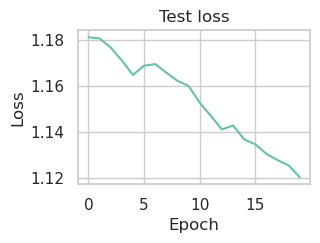

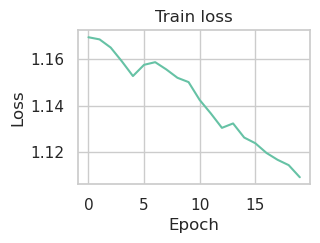

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


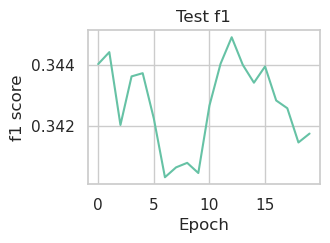

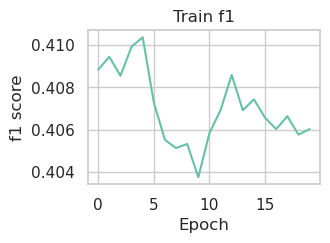

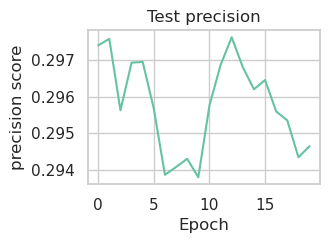

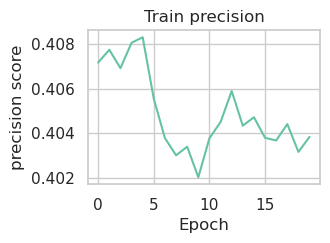

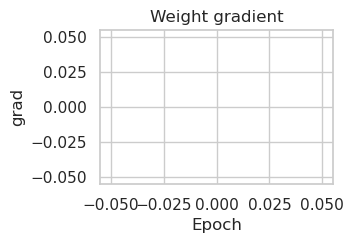

In [ ]:
train_enc_model_enc_data(learning_rate=1e-8, l1=0.005, epochs=20)

  5%|▌         | 1/20 [24:58<7:54:34, 1498.66s/it]

Test Loss at epoch #1 is 1.181720495223999|Test Accuracy at epoch #1 is 0.40560001134872437|Precision is 0.29944899678230286|F1-score is 0.3465259373188019|AUC is 0.3677479326725006


 10%|█         | 2/20 [50:00<7:30:11, 1500.65s/it]

Test Loss at epoch #2 is 1.1782125234603882|Test Accuracy at epoch #2 is 0.4036000072956085|Precision is 0.29739493131637573|F1-score is 0.344038724899292|AUC is 0.3651180863380432


 15%|█▌        | 3/20 [1:14:57<7:04:40, 1498.88s/it]

Test Loss at epoch #3 is 1.179270625114441|Test Accuracy at epoch #3 is 0.4002000093460083|Precision is 0.294162392616272|F1-score is 0.34029915928840637|AUC is 0.36161014437675476


 20%|██        | 4/20 [1:39:59<6:40:00, 1500.03s/it]

Test Loss at epoch #4 is 1.1778221130371094|Test Accuracy at epoch #4 is 0.39910000562667847|Precision is 0.2932344973087311|F1-score is 0.3393073081970215|AUC is 0.35981041193008423


 25%|██▌       | 5/20 [2:04:55<6:14:39, 1498.66s/it]

Test Loss at epoch #5 is 1.1747287511825562|Test Accuracy at epoch #5 is 0.3986000120639801|Precision is 0.2927200198173523|F1-score is 0.3386848568916321|AUC is 0.35964563488960266


 30%|███       | 6/20 [2:29:58<5:50:00, 1500.01s/it]

Test Loss at epoch #6 is 1.171892523765564|Test Accuracy at epoch #6 is 0.3977000117301941|Precision is 0.2913490831851959|F1-score is 0.33674705028533936|AUC is 0.3571537137031555


 35%|███▌      | 7/20 [2:55:01<5:25:12, 1500.96s/it]

Test Loss at epoch #7 is 1.1719781160354614|Test Accuracy at epoch #7 is 0.39719998836517334|Precision is 0.29099220037460327|F1-score is 0.33641567826271057|AUC is 0.35651895403862


 40%|████      | 8/20 [3:20:06<5:00:27, 1502.32s/it]

Test Loss at epoch #8 is 1.1674131155014038|Test Accuracy at epoch #8 is 0.39800000190734863|Precision is 0.2919124662876129|F1-score is 0.33758804202079773|AUC is 0.35719069838523865


 45%|████▌     | 9/20 [3:45:24<4:36:19, 1507.20s/it]

Test Loss at epoch #9 is 1.166201114654541|Test Accuracy at epoch #9 is 0.39629998803138733|Precision is 0.2908124625682831|F1-score is 0.3366662859916687|AUC is 0.35576674342155457


 50%|█████     | 10/20 [4:10:46<4:11:59, 1511.98s/it]

Test Loss at epoch #10 is 1.1576564311981201|Test Accuracy at epoch #10 is 0.3982999920845032|Precision is 0.29247432947158813|F1-score is 0.33842769265174866|AUC is 0.3583051264286041


 55%|█████▌    | 11/20 [4:35:48<3:46:19, 1508.78s/it]

Test Loss at epoch #11 is 1.1546735763549805|Test Accuracy at epoch #11 is 0.3977999985218048|Precision is 0.29235440492630005|F1-score is 0.3385325074195862|AUC is 0.3582788407802582


 60%|██████    | 12/20 [5:00:47<3:20:47, 1505.92s/it]

Test Loss at epoch #12 is 1.1446459293365479|Test Accuracy at epoch #12 is 0.3993000090122223|Precision is 0.2934245467185974|F1-score is 0.3395272195339203|AUC is 0.3600698709487915


 65%|██████▌   | 13/20 [5:25:34<2:55:01, 1500.22s/it]

Test Loss at epoch #13 is 1.1452356576919556|Test Accuracy at epoch #13 is 0.39739999175071716|Precision is 0.29181697964668274|F1-score is 0.3378022015094757|AUC is 0.3577544689178467


 70%|███████   | 14/20 [5:50:28<2:29:48, 1498.08s/it]

Test Loss at epoch #14 is 1.1407272815704346|Test Accuracy at epoch #14 is 0.3968999981880188|Precision is 0.29138192534446716|F1-score is 0.3373255729675293|AUC is 0.35775303840637207


 75%|███████▌  | 15/20 [6:15:19<2:04:40, 1496.02s/it]

Test Loss at epoch #15 is 1.138088345527649|Test Accuracy at epoch #15 is 0.3968000113964081|Precision is 0.29116809368133545|F1-score is 0.3369971513748169|AUC is 0.3561306297779083


 80%|████████  | 16/20 [6:40:10<1:39:38, 1494.69s/it]

Test Loss at epoch #16 is 1.1335852146148682|Test Accuracy at epoch #16 is 0.39579999446868896|Precision is 0.2900589108467102|F1-score is 0.3356058895587921|AUC is 0.35499078035354614


 85%|████████▌ | 17/20 [7:04:58<1:14:37, 1492.49s/it]

Test Loss at epoch #17 is 1.133346676826477|Test Accuracy at epoch #17 is 0.3955000042915344|Precision is 0.2899734079837799|F1-score is 0.3356412649154663|AUC is 0.3548829257488251


 90%|█████████ | 18/20 [7:29:50<49:44, 1492.39s/it]  

Test Loss at epoch #18 is 1.1263608932495117|Test Accuracy at epoch #18 is 0.3962000012397766|Precision is 0.2902796268463135|F1-score is 0.33575358986854553|AUC is 0.3567506968975067


 95%|█████████▌| 19/20 [7:54:40<24:51, 1491.73s/it]

Test Loss at epoch #19 is 1.1198457479476929|Test Accuracy at epoch #19 is 0.39800000190734863|Precision is 0.29207074642181396|F1-score is 0.3378794491291046|AUC is 0.35943901538848877


100%|██████████| 20/20 [8:19:33<00:00, 1498.68s/it]

Test Loss at epoch #20 is 1.1133888959884644|Test Accuracy at epoch #20 is 0.39820000529289246|Precision is 0.2928909957408905|F1-score is 0.3392621874809265|AUC is 0.35978391766548157
Results
f1-score test set: 0.3393
accuracy test set: 0.3982
precision test set: 0.2929
AUC score test set: 0.3598


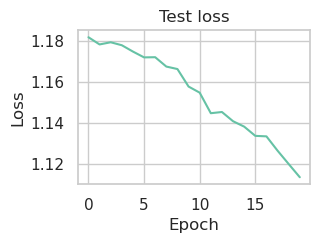

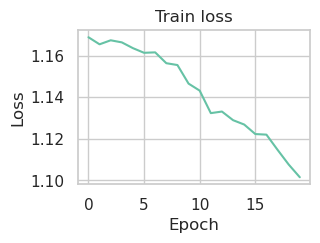

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


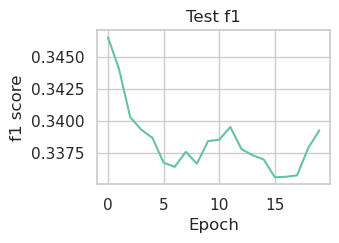

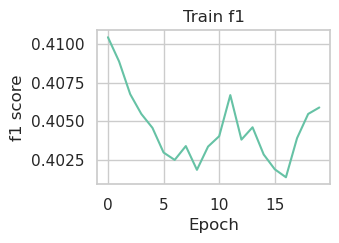

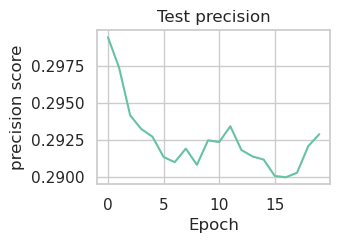

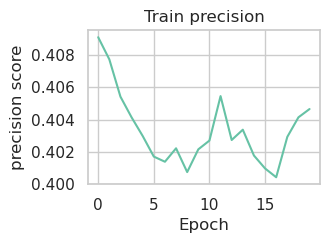

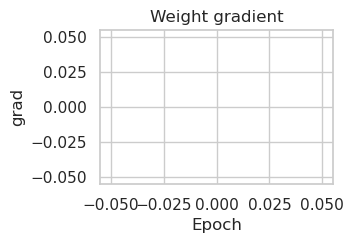

In [ ]:
train_enc_model_enc_data(learning_rate=1e-9, l1=0.005, epochs=20)

  2%|▏         | 1/50 [25:50<21:06:08, 1550.37s/it]

Test Loss at epoch #1 is 1.1857348680496216|Test Accuracy at epoch #1 is 0.4052000045776367|Precision is 0.2994500398635864|F1-score is 0.34680429100990295|AUC is 0.36613672971725464


  4%|▍         | 2/50 [51:37<20:38:34, 1548.21s/it]

Test Loss at epoch #2 is 1.1850203275680542|Test Accuracy at epoch #2 is 0.40290001034736633|Precision is 0.2970767021179199|F1-score is 0.3439182639122009|AUC is 0.3642685115337372


  6%|▌         | 3/50 [1:17:23<20:12:01, 1547.26s/it]

Test Loss at epoch #3 is 1.1901962757110596|Test Accuracy at epoch #3 is 0.3993000090122223|Precision is 0.29381638765335083|F1-score is 0.3402526080608368|AUC is 0.36038243770599365


  8%|▊         | 4/50 [1:43:09<19:46:03, 1547.02s/it]

Test Loss at epoch #4 is 1.181394338607788|Test Accuracy at epoch #4 is 0.40070000290870667|Precision is 0.2951441705226898|F1-score is 0.34179022908210754|AUC is 0.3617480993270874


 10%|█         | 5/50 [2:08:55<19:19:58, 1546.64s/it]

Test Loss at epoch #5 is 1.1833893060684204|Test Accuracy at epoch #5 is 0.4000999927520752|Precision is 0.29449716210365295|F1-score is 0.3409864902496338|AUC is 0.3613269329071045


 12%|█▏        | 6/50 [2:34:42<18:54:13, 1546.66s/it]

Test Loss at epoch #6 is 1.1859697103500366|Test Accuracy at epoch #6 is 0.3977999985218048|Precision is 0.29211774468421936|F1-score is 0.3380962908267975|AUC is 0.35824474692344666


 14%|█▍        | 7/50 [3:00:28<18:28:19, 1546.49s/it]

Test Loss at epoch #7 is 1.1902766227722168|Test Accuracy at epoch #7 is 0.3953000009059906|Precision is 0.28986331820487976|F1-score is 0.33556753396987915|AUC is 0.3547339141368866


 16%|█▌        | 8/50 [3:26:15<18:02:33, 1546.52s/it]

Test Loss at epoch #8 is 1.1868054866790771|Test Accuracy at epoch #8 is 0.39419999718666077|Precision is 0.2889394760131836|F1-score is 0.3345782160758972|AUC is 0.354417085647583


 18%|█▊        | 9/50 [3:52:01<17:36:40, 1546.35s/it]

Test Loss at epoch #9 is 1.1865837574005127|Test Accuracy at epoch #9 is 0.3928999900817871|Precision is 0.2874239981174469|F1-score is 0.33263713121414185|AUC is 0.3520912230014801


 20%|██        | 10/50 [4:17:47<17:10:55, 1546.38s/it]

Test Loss at epoch #10 is 1.185624361038208|Test Accuracy at epoch #10 is 0.3937000036239624|Precision is 0.28834471106529236|F1-score is 0.3338094651699066|AUC is 0.3530689775943756


 22%|██▏       | 11/50 [4:43:33<16:44:58, 1546.11s/it]

Test Loss at epoch #11 is 1.1860450506210327|Test Accuracy at epoch #11 is 0.39309999346733093|Precision is 0.28720974922180176|F1-score is 0.332122802734375|AUC is 0.35297104716300964


 24%|██▍       | 12/50 [5:09:19<16:19:17, 1546.24s/it]

Test Loss at epoch #12 is 1.1859878301620483|Test Accuracy at epoch #12 is 0.3926999866962433|Precision is 0.2869912385940552|F1-score is 0.33197668194770813|AUC is 0.3519905209541321


 26%|██▌       | 13/50 [5:35:05<15:53:22, 1546.02s/it]

Test Loss at epoch #13 is 1.1817632913589478|Test Accuracy at epoch #13 is 0.39259999990463257|Precision is 0.2872602939605713|F1-score is 0.3325274586677551|AUC is 0.3514420986175537


 28%|██▊       | 14/50 [6:00:51<15:27:40, 1546.13s/it]

Test Loss at epoch #14 is 1.179262638092041|Test Accuracy at epoch #14 is 0.3917999863624573|Precision is 0.28650084137916565|F1-score is 0.3316483497619629|AUC is 0.35061076283454895


 30%|███       | 15/50 [6:26:37<15:01:50, 1546.00s/it]

Test Loss at epoch #15 is 1.1786961555480957|Test Accuracy at epoch #15 is 0.3921999931335449|Precision is 0.2870423197746277|F1-score is 0.33238136768341064|AUC is 0.350363552570343


 32%|███▏      | 16/50 [6:52:23<14:36:10, 1546.20s/it]

Test Loss at epoch #16 is 1.1742862462997437|Test Accuracy at epoch #16 is 0.39239999651908875|Precision is 0.28731271624565125|F1-score is 0.3327476382255554|AUC is 0.35133302211761475


 34%|███▍      | 17/50 [7:18:09<14:10:19, 1546.05s/it]

Test Loss at epoch #17 is 1.1679607629776|Test Accuracy at epoch #17 is 0.39340001344680786|Precision is 0.2881806194782257|F1-score is 0.33369946479797363|AUC is 0.3526253402233124


 36%|███▌      | 18/50 [7:43:56<13:44:39, 1546.22s/it]

Test Loss at epoch #18 is 1.1620451211929321|Test Accuracy at epoch #18 is 0.39430001378059387|Precision is 0.2893141210079193|F1-score is 0.3351992070674896|AUC is 0.35294055938720703


 38%|███▊      | 19/50 [8:09:42<13:18:48, 1546.07s/it]

Test Loss at epoch #19 is 1.154288411140442|Test Accuracy at epoch #19 is 0.3952000141143799|Precision is 0.29028594493865967|F1-score is 0.33640551567077637|AUC is 0.3557068705558777


 40%|████      | 20/50 [8:35:28<12:53:05, 1546.18s/it]

Test Loss at epoch #20 is 1.1521751880645752|Test Accuracy at epoch #20 is 0.39590001106262207|Precision is 0.2915407717227936|F1-score is 0.338262677192688|AUC is 0.35540667176246643


 42%|████▏     | 21/50 [9:01:14<12:27:16, 1546.07s/it]

Test Loss at epoch #21 is 1.1488925218582153|Test Accuracy at epoch #21 is 0.3953000009059906|Precision is 0.2911320626735687|F1-score is 0.33789554238319397|AUC is 0.3556203544139862


 44%|████▍     | 22/50 [9:27:00<12:01:32, 1546.18s/it]

Test Loss at epoch #22 is 1.1446915864944458|Test Accuracy at epoch #22 is 0.39660000801086426|Precision is 0.2922408878803253|F1-score is 0.3391018509864807|AUC is 0.35638633370399475


 46%|████▌     | 23/50 [9:52:46<11:35:43, 1546.06s/it]

Test Loss at epoch #23 is 1.141452670097351|Test Accuracy at epoch #23 is 0.3959999978542328|Precision is 0.2914382815361023|F1-score is 0.33800965547561646|AUC is 0.3557867407798767


 48%|████▊     | 24/50 [10:18:32<11:09:59, 1546.12s/it]

Test Loss at epoch #24 is 1.1377898454666138|Test Accuracy at epoch #24 is 0.39590001106262207|Precision is 0.2917766869068146|F1-score is 0.33869731426239014|AUC is 0.35545140504837036


 50%|█████     | 25/50 [10:44:18<10:44:08, 1545.96s/it]

Test Loss at epoch #25 is 1.1355289220809937|Test Accuracy at epoch #25 is 0.39469999074935913|Precision is 0.2904869616031647|F1-score is 0.33709341287612915|AUC is 0.35401225090026855


 52%|█████▏    | 26/50 [11:10:04<10:18:25, 1546.06s/it]

Test Loss at epoch #26 is 1.1306321620941162|Test Accuracy at epoch #26 is 0.39480000734329224|Precision is 0.29109394550323486|F1-score is 0.3381452262401581|AUC is 0.3544369339942932


 54%|█████▍    | 27/50 [11:35:50<9:52:35, 1545.91s/it] 

Test Loss at epoch #27 is 1.1250908374786377|Test Accuracy at epoch #27 is 0.39590001106262207|Precision is 0.2916194796562195|F1-score is 0.33840763568878174|AUC is 0.3558071255683899


 56%|█████▌    | 28/50 [12:01:36<9:26:51, 1545.98s/it]

Test Loss at epoch #28 is 1.126657247543335|Test Accuracy at epoch #28 is 0.39399999380111694|Precision is 0.29018276929855347|F1-score is 0.33698031306266785|AUC is 0.35356369614601135


 58%|█████▊    | 29/50 [12:27:21<9:01:03, 1545.86s/it]

Test Loss at epoch #29 is 1.1225333213806152|Test Accuracy at epoch #29 is 0.3937000036239624|Precision is 0.29001882672309875|F1-score is 0.3368697464466095|AUC is 0.35298654437065125


 60%|██████    | 30/50 [12:53:08<8:35:19, 1545.98s/it]

Test Loss at epoch #30 is 1.1170011758804321|Test Accuracy at epoch #30 is 0.39489999413490295|Precision is 0.2907547056674957|F1-score is 0.3374575674533844|AUC is 0.35392335057258606


 62%|██████▏   | 31/50 [13:18:53<8:09:29, 1545.79s/it]

Test Loss at epoch #31 is 1.1140871047973633|Test Accuracy at epoch #31 is 0.3928999900817871|Precision is 0.28918612003326416|F1-score is 0.33584946393966675|AUC is 0.3535860776901245


 64%|██████▍   | 32/50 [13:44:30<7:42:54, 1543.03s/it]

Test Loss at epoch #32 is 1.1154863834381104|Test Accuracy at epoch #32 is 0.3928999900817871|Precision is 0.28894755244255066|F1-score is 0.33541324734687805|AUC is 0.3519227206707001


 66%|██████▌   | 33/50 [14:09:51<7:15:19, 1536.42s/it]

Test Loss at epoch #33 is 1.1153327226638794|Test Accuracy at epoch #33 is 0.390500009059906|Precision is 0.28692540526390076|F1-score is 0.33322393894195557|AUC is 0.35012784600257874


 68%|██████▊   | 34/50 [14:34:17<6:44:06, 1515.38s/it]

Test Loss at epoch #34 is 1.107343316078186|Test Accuracy at epoch #34 is 0.3919000029563904|Precision is 0.2882441580295563|F1-score is 0.3347555100917816|AUC is 0.35215380787849426


 70%|███████   | 35/50 [14:59:22<6:18:03, 1512.24s/it]

Test Loss at epoch #35 is 1.1045156717300415|Test Accuracy at epoch #35 is 0.39169999957084656|Precision is 0.28789591789245605|F1-score is 0.33424538373947144|AUC is 0.35176461935043335


 72%|███████▏  | 36/50 [15:24:25<5:52:13, 1509.56s/it]

Test Loss at epoch #36 is 1.1036027669906616|Test Accuracy at epoch #36 is 0.3912000060081482|Precision is 0.2878645360469818|F1-score is 0.334499329328537|AUC is 0.3521883487701416


 74%|███████▍  | 37/50 [15:49:28<5:26:36, 1507.46s/it]

Test Loss at epoch #37 is 1.1074246168136597|Test Accuracy at epoch #37 is 0.39100000262260437|Precision is 0.2876763939857483|F1-score is 0.33428072929382324|AUC is 0.34916549921035767


 76%|███████▌  | 38/50 [16:14:09<4:59:54, 1499.53s/it]

Test Loss at epoch #38 is 1.1076310873031616|Test Accuracy at epoch #38 is 0.38999998569488525|Precision is 0.28641417622566223|F1-score is 0.33260393142700195|AUC is 0.34873679280281067


 78%|███████▊  | 39/50 [16:38:32<4:32:54, 1488.61s/it]

Test Loss at epoch #39 is 1.1078495979309082|Test Accuracy at epoch #39 is 0.38909998536109924|Precision is 0.28592926263809204|F1-score is 0.33227676153182983|AUC is 0.34730666875839233


 80%|████████  | 40/50 [17:02:53<4:06:44, 1480.42s/it]

Test Loss at epoch #40 is 1.1021701097488403|Test Accuracy at epoch #40 is 0.391400009393692|Precision is 0.28773319721221924|F1-score is 0.33413568139076233|AUC is 0.34893229603767395


 82%|████████▏ | 41/50 [17:29:20<3:46:50, 1512.30s/it]

Test Loss at epoch #41 is 1.0961482524871826|Test Accuracy at epoch #41 is 0.39259999990463257|Precision is 0.2890227735042572|F1-score is 0.33573928475379944|AUC is 0.35163652896881104


 84%|████████▍ | 42/50 [17:54:23<3:21:16, 1509.59s/it]

Test Loss at epoch #42 is 1.092301845550537|Test Accuracy at epoch #42 is 0.39320001006126404|Precision is 0.2896668612957001|F1-score is 0.336540549993515|AUC is 0.3520565330982208


 86%|████████▌ | 43/50 [18:19:06<2:55:11, 1501.61s/it]

Test Loss at epoch #43 is 1.0911749601364136|Test Accuracy at epoch #43 is 0.39430001378059387|Precision is 0.2907414436340332|F1-score is 0.33781567215919495|AUC is 0.3521736264228821


 88%|████████▊ | 44/50 [18:43:46<2:29:29, 1494.96s/it]

Test Loss at epoch #44 is 1.0899089574813843|Test Accuracy at epoch #44 is 0.39320001006126404|Precision is 0.29021963477134705|F1-score is 0.33755457401275635|AUC is 0.35207992792129517


 90%|█████████ | 45/50 [19:08:26<2:04:13, 1490.62s/it]

Test Loss at epoch #45 is 1.087968349456787|Test Accuracy at epoch #45 is 0.39250001311302185|Precision is 0.2896021008491516|F1-score is 0.33686280250549316|AUC is 0.3506848216056824


 92%|█████████▏| 46/50 [19:33:13<1:39:17, 1489.48s/it]

Test Loss at epoch #46 is 1.0897197723388672|Test Accuracy at epoch #46 is 0.3901999890804291|Precision is 0.28684359788894653|F1-score is 0.3332604467868805|AUC is 0.3476199209690094


 94%|█████████▍| 47/50 [19:58:12<1:14:37, 1492.50s/it]

Test Loss at epoch #47 is 1.0821974277496338|Test Accuracy at epoch #47 is 0.3917999863624573|Precision is 0.2881898581981659|F1-score is 0.33471888303756714|AUC is 0.35033708810806274


 96%|█████████▌| 48/50 [20:23:12<49:49, 1494.65s/it]  

Test Loss at epoch #48 is 1.0774509906768799|Test Accuracy at epoch #48 is 0.39070001244544983|Precision is 0.2874341607093811|F1-score is 0.3340255618095398|AUC is 0.34841567277908325


 98%|█████████▊| 49/50 [20:48:11<24:55, 1495.86s/it]

Test Loss at epoch #49 is 1.0729632377624512|Test Accuracy at epoch #49 is 0.3889999985694885|Precision is 0.2860364615917206|F1-score is 0.33253222703933716|AUC is 0.3469989597797394


100%|██████████| 50/50 [21:13:19<00:00, 1528.00s/it]

Test Loss at epoch #50 is 1.0643426179885864|Test Accuracy at epoch #50 is 0.3912000060081482|Precision is 0.28810372948646545|F1-score is 0.3349355459213257|AUC is 0.34959590435028076
Results
loss test set: 1.0643
f1-score test set: 0.3349
accuracy test set: 0.3912
precision test set: 0.2881
AUC score test set: 0.3496


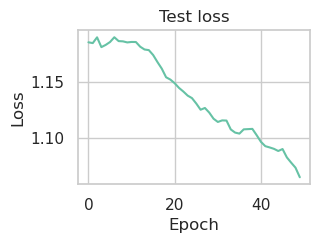

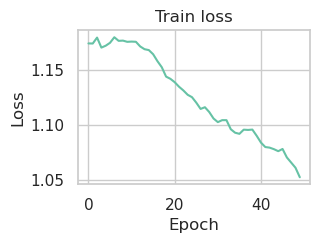

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


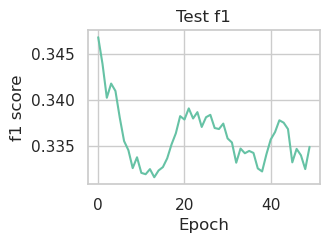

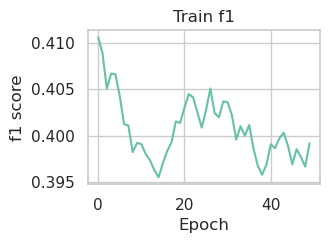

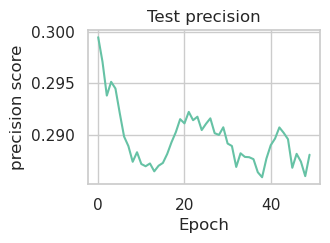

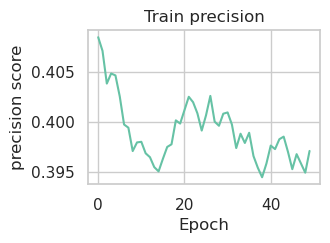

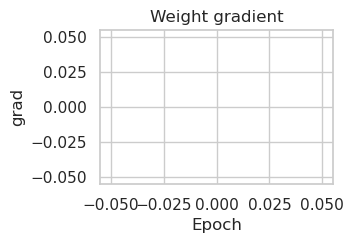

In [ ]:
train_enc_model_enc_data(learning_rate=1e-7, l1=0.005, epochs=50) # 2nd polynommial

  2%|▏         | 1/50 [23:37<19:17:21, 1417.18s/it]

Test Loss at epoch #1 is 0.9174799919128418|Test Accuracy at epoch #1 is 0.4970000088214874|Precision is 0.3858042359352112|F1-score is 0.44566893577575684|AUC is 0.5052585005760193


  4%|▍         | 2/50 [47:51<19:11:09, 1438.94s/it]

Test Loss at epoch #2 is 0.7457079291343689|Test Accuracy at epoch #2 is 0.578499972820282|Precision is 0.46345198154449463|F1-score is 0.5347168445587158|AUC is 0.6286410093307495


  6%|▌         | 3/50 [1:12:23<18:59:06, 1454.17s/it]

Test Loss at epoch #3 is 0.6360390186309814|Test Accuracy at epoch #3 is 0.651199996471405|Precision is 0.5333462357521057|F1-score is 0.6127026677131653|AUC is 0.726264238357544


  8%|▊         | 4/50 [1:36:55<18:40:11, 1461.13s/it]

Test Loss at epoch #4 is 0.5645761489868164|Test Accuracy at epoch #4 is 0.7059999704360962|Precision is 0.5881540179252625|F1-score is 0.6695886850357056|AUC is 0.796620786190033


 10%|█         | 5/50 [2:01:27<18:18:51, 1465.14s/it]

Test Loss at epoch #5 is 0.5164008736610413|Test Accuracy at epoch #5 is 0.7472000122070312|Precision is 0.6331904530525208|F1-score is 0.7104901671409607|AUC is 0.8448368906974792


 12%|█▏        | 6/50 [2:26:00<17:56:16, 1467.64s/it]

Test Loss at epoch #6 is 0.4838099181652069|Test Accuracy at epoch #6 is 0.7820000052452087|Precision is 0.6739633679389954|F1-score is 0.7460391521453857|AUC is 0.875991702079773


 14%|█▍        | 7/50 [2:50:33<17:33:01, 1469.34s/it]

Test Loss at epoch #7 is 0.4581718146800995|Test Accuracy at epoch #7 is 0.8098000288009644|Precision is 0.7105779647827148|F1-score is 0.7740556001663208|AUC is 0.8990312814712524


 16%|█▌        | 8/50 [3:15:05<17:09:10, 1470.25s/it]

Test Loss at epoch #8 is 0.44125574827194214|Test Accuracy at epoch #8 is 0.8271999955177307|Precision is 0.7368894815444946|F1-score is 0.791203498840332|AUC is 0.9133249521255493


 18%|█▊        | 9/50 [3:39:37<16:45:00, 1470.74s/it]

Test Loss at epoch #9 is 0.42786476016044617|Test Accuracy at epoch #9 is 0.8436999917030334|Precision is 0.7632189393043518|F1-score is 0.8081031441688538|AUC is 0.9238117337226868


 20%|██        | 10/50 [4:04:08<16:20:35, 1470.88s/it]

Test Loss at epoch #10 is 0.4169798791408539|Test Accuracy at epoch #10 is 0.857200026512146|Precision is 0.7848851084709167|F1-score is 0.8226968050003052|AUC is 0.9317020773887634


 58%|█████▊    | 29/50 [11:42:33<8:22:13, 1434.92s/it]

Test Loss at epoch #29 is 0.3742755651473999|Test Accuracy at epoch #29 is 0.8988000154495239|Precision is 0.8634372353553772|F1-score is 0.8688099384307861|AUC is 0.959841787815094


 60%|██████    | 30/50 [12:07:03<8:01:48, 1445.45s/it]

Test Loss at epoch #30 is 0.374114990234375|Test Accuracy at epoch #30 is 0.8988000154495239|Precision is 0.8638122081756592|F1-score is 0.8687418699264526|AUC is 0.9600703716278076


 62%|██████▏   | 31/50 [12:31:37<7:40:22, 1453.81s/it]

Test Loss at epoch #31 is 0.3742833137512207|Test Accuracy at epoch #31 is 0.8980000019073486|Precision is 0.863342821598053|F1-score is 0.8676012754440308|AUC is 0.9603561162948608


 64%|██████▍   | 32/50 [12:56:10<7:17:54, 1459.70s/it]

Test Loss at epoch #32 is 0.3744448125362396|Test Accuracy at epoch #32 is 0.8982999920845032|Precision is 0.8649559617042542|F1-score is 0.8677675127983093|AUC is 0.9604618549346924


 66%|██████▌   | 33/50 [13:20:43<6:54:45, 1463.83s/it]

Test Loss at epoch #33 is 0.3744920492172241|Test Accuracy at epoch #33 is 0.8992000222206116|Precision is 0.866787850856781|F1-score is 0.8688183426856995|AUC is 0.9607522487640381


 68%|██████▊   | 34/50 [13:45:16<6:31:01, 1466.32s/it]

Test Loss at epoch #34 is 0.37493908405303955|Test Accuracy at epoch #34 is 0.8999000191688538|Precision is 0.8672199249267578|F1-score is 0.8698140382766724|AUC is 0.9610255360603333


 70%|███████   | 35/50 [14:09:49<6:07:05, 1468.38s/it]

Test Loss at epoch #35 is 0.3753783106803894|Test Accuracy at epoch #35 is 0.9002000093460083|Precision is 0.8694292306900024|F1-score is 0.8698826432228088|AUC is 0.9611510038375854


 72%|███████▏  | 36/50 [14:34:24<5:43:04, 1470.33s/it]

Test Loss at epoch #36 is 0.3749527931213379|Test Accuracy at epoch #36 is 0.9006999731063843|Precision is 0.8709508776664734|F1-score is 0.8703824281692505|AUC is 0.9611923694610596


 74%|███████▍  | 37/50 [14:58:59<5:18:53, 1471.84s/it]

Test Loss at epoch #37 is 0.37485605478286743|Test Accuracy at epoch #37 is 0.8999000191688538|Precision is 0.869905948638916|F1-score is 0.8693382143974304|AUC is 0.9613549709320068


 76%|███████▌  | 38/50 [15:23:34<4:54:33, 1472.75s/it]

Test Loss at epoch #38 is 0.3748777210712433|Test Accuracy at epoch #38 is 0.8996999859809875|Precision is 0.8694517016410828|F1-score is 0.8691112995147705|AUC is 0.9615163803100586


 78%|███████▊  | 39/50 [15:48:09<4:30:08, 1473.47s/it]

Test Loss at epoch #39 is 0.3748949468135834|Test Accuracy at epoch #39 is 0.899399995803833|Precision is 0.869929313659668|F1-score is 0.8685654401779175|AUC is 0.9616446495056152


 80%|████████  | 40/50 [16:12:43<4:05:36, 1473.69s/it]

Test Loss at epoch #40 is 0.3750534653663635|Test Accuracy at epoch #40 is 0.8988999724388123|Precision is 0.8705357313156128|F1-score is 0.867687463760376|AUC is 0.9616607427597046


 82%|████████▏ | 41/50 [16:37:19<3:41:07, 1474.19s/it]

Test Loss at epoch #41 is 0.37509945034980774|Test Accuracy at epoch #41 is 0.8988000154495239|Precision is 0.8710865378379822|F1-score is 0.8674351572990417|AUC is 0.9615867733955383


 84%|████████▍ | 42/50 [17:01:54<3:16:35, 1474.45s/it]

Test Loss at epoch #42 is 0.3758241832256317|Test Accuracy at epoch #42 is 0.8984000086784363|Precision is 0.8713419437408447|F1-score is 0.8667715787887573|AUC is 0.9617263078689575


 86%|████████▌ | 43/50 [17:26:29<2:52:02, 1474.69s/it]

Test Loss at epoch #43 is 0.3758317530155182|Test Accuracy at epoch #43 is 0.8986999988555908|Precision is 0.8716394305229187|F1-score is 0.8671823740005493|AUC is 0.9616807103157043


 88%|████████▊ | 44/50 [17:51:02<2:27:25, 1474.31s/it]

Test Loss at epoch #44 is 0.37501659989356995|Test Accuracy at epoch #44 is 0.8981000185012817|Precision is 0.8728139996528625|F1-score is 0.8660444617271423|AUC is 0.9614501595497131


 90%|█████████ | 45/50 [18:15:36<2:02:51, 1474.24s/it]

Test Loss at epoch #45 is 0.37602293491363525|Test Accuracy at epoch #45 is 0.8986999988555908|Precision is 0.8744025230407715|F1-score is 0.8666929602622986|AUC is 0.9614338874816895


 92%|█████████▏| 46/50 [18:40:11<1:38:17, 1474.42s/it]

Test Loss at epoch #46 is 0.3759101629257202|Test Accuracy at epoch #46 is 0.8985999822616577|Precision is 0.8749667406082153|F1-score is 0.8664383292198181|AUC is 0.9615055918693542


 94%|█████████▍| 47/50 [19:04:47<1:13:44, 1474.68s/it]

Test Loss at epoch #47 is 0.3763589859008789|Test Accuracy at epoch #47 is 0.8991000056266785|Precision is 0.8761321306228638|F1-score is 0.8670093417167664|AUC is 0.9615097045898438


 96%|█████████▌| 48/50 [19:29:22<49:09, 1474.78s/it]  

Test Loss at epoch #48 is 0.3765352666378021|Test Accuracy at epoch #48 is 0.8989999890327454|Precision is 0.8769025206565857|F1-score is 0.8667194247245789|AUC is 0.9615857005119324


 98%|█████████▊| 49/50 [19:53:55<24:34, 1474.46s/it]

Test Loss at epoch #49 is 0.3765360713005066|Test Accuracy at epoch #49 is 0.8991000056266785|Precision is 0.8777421116828918|F1-score is 0.8667283058166504|AUC is 0.9616222977638245


100%|██████████| 50/50 [20:18:31<00:00, 1462.22s/it]

Test Loss at epoch #50 is 0.3758218288421631|Test Accuracy at epoch #50 is 0.8999000191688538|Precision is 0.8786095976829529|F1-score is 0.8678199052810669|AUC is 0.9616910815238953
Results
loss test set: 0.3758
f1-score test set: 0.8678
accuracy test set: 0.8999
precision test set: 0.8786
AUC score test set: 0.9617


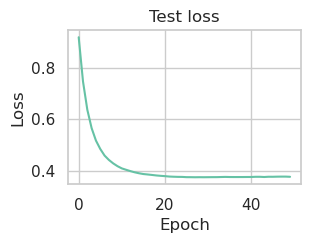

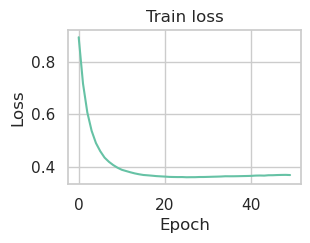

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


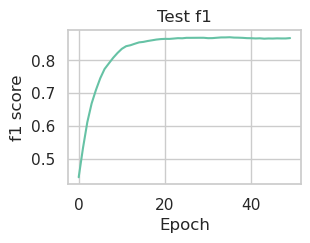

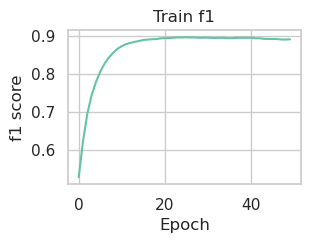

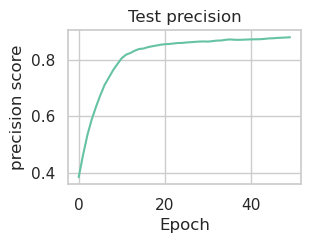

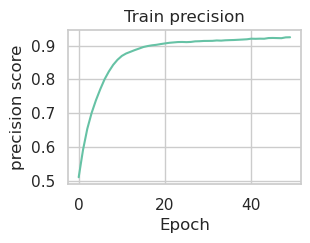

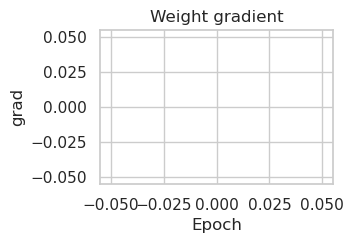

In [ ]:
train_enc_model_enc_data(learning_rate=1e-6, l1=0.005, epochs=50) # 1st polynomial

In [ ]:
train_enc_model_enc_data(learning_rate=1e-6, l1=0.005, epochs=50) # 1st polynomial

  2%|▏         | 1/50 [20:44<16:56:02, 1244.13s/it]

Test Loss at epoch #1 is 0.8981513381004333|Test Accuracy at epoch #1 is 0.5163000226020813|Precision is 0.40459901094436646|F1-score is 0.46816933155059814|AUC is 0.5344675779342651


  4%|▍         | 2/50 [41:22<16:32:36, 1240.75s/it]

Test Loss at epoch #2 is 0.7086325287818909|Test Accuracy at epoch #2 is 0.6177999973297119|Precision is 0.5010534524917603|F1-score is 0.5778661370277405|AUC is 0.6834434270858765


  6%|▌         | 3/50 [1:02:03<16:11:51, 1240.67s/it]

Test Loss at epoch #3 is 0.593163251876831|Test Accuracy at epoch #3 is 0.6908000111579895|Precision is 0.5717328190803528|F1-score is 0.6563680768013|AUC is 0.7826991081237793


  8%|▊         | 4/50 [1:22:42<15:50:42, 1240.06s/it]

Test Loss at epoch #4 is 0.5202301144599915|Test Accuracy at epoch #4 is 0.7432000041007996|Precision is 0.6259207725524902|F1-score is 0.7100270986557007|AUC is 0.8417693376541138


 10%|█         | 5/50 [1:43:22<15:30:09, 1240.22s/it]

Test Loss at epoch #5 is 0.4725635349750519|Test Accuracy at epoch #5 is 0.7767000198364258|Precision is 0.6633319854736328|F1-score is 0.7442446351051331|AUC is 0.8761814832687378


 12%|█▏        | 6/50 [2:04:04<15:10:00, 1240.92s/it]

Test Loss at epoch #6 is 0.43927836418151855|Test Accuracy at epoch #6 is 0.7991999983787537|Precision is 0.6898273229598999|F1-score is 0.7675926089286804|AUC is 0.8971281051635742


 14%|█▍        | 7/50 [2:24:47<14:49:48, 1241.60s/it]

Test Loss at epoch #7 is 0.4156368672847748|Test Accuracy at epoch #7 is 0.8169999718666077|Precision is 0.7119576930999756|F1-score is 0.7861649990081787|AUC is 0.9105561971664429


 16%|█▌        | 8/50 [2:45:30<14:29:24, 1242.01s/it]

Test Loss at epoch #8 is 0.3989725708961487|Test Accuracy at epoch #8 is 0.8281999826431274|Precision is 0.726203203201294|F1-score is 0.7980723977088928|AUC is 0.9190719723701477


 18%|█▊        | 9/50 [3:06:10<14:08:06, 1241.13s/it]

Test Loss at epoch #9 is 0.3862694799900055|Test Accuracy at epoch #9 is 0.8363000154495239|Precision is 0.7372515201568604|F1-score is 0.8065240383148193|AUC is 0.9250259399414062


 20%|██        | 10/50 [3:26:48<13:46:55, 1240.40s/it]

Test Loss at epoch #10 is 0.3761154115200043|Test Accuracy at epoch #10 is 0.8418999910354614|Precision is 0.7440398931503296|F1-score is 0.8128329515457153|AUC is 0.9295036792755127


 22%|██▏       | 11/50 [3:47:26<13:25:49, 1239.72s/it]

Test Loss at epoch #11 is 0.36923617124557495|Test Accuracy at epoch #11 is 0.84579998254776|Precision is 0.7494012713432312|F1-score is 0.8169950246810913|AUC is 0.932131826877594


 24%|██▍       | 12/50 [4:08:05<13:04:57, 1239.41s/it]

Test Loss at epoch #12 is 0.3644469976425171|Test Accuracy at epoch #12 is 0.8457000255584717|Precision is 0.748157799243927|F1-score is 0.8173316121101379|AUC is 0.934287428855896


 26%|██▌       | 13/50 [4:28:44<12:44:15, 1239.34s/it]

Test Loss at epoch #13 is 0.36350399255752563|Test Accuracy at epoch #13 is 0.8474000096321106|Precision is 0.7496212720870972|F1-score is 0.8194937109947205|AUC is 0.9352604150772095


 28%|██▊       | 14/50 [4:49:23<12:23:26, 1239.06s/it]

Test Loss at epoch #14 is 0.3733583092689514|Test Accuracy at epoch #14 is 0.8417999744415283|Precision is 0.7396210432052612|F1-score is 0.8145369291305542|AUC is 0.9339942932128906


 30%|███       | 15/50 [5:10:01<12:02:41, 1238.89s/it]

Test Loss at epoch #15 is 0.42097538709640503|Test Accuracy at epoch #15 is 0.8217999935150146|Precision is 0.7090723514556885|F1-score is 0.7960631847381592|AUC is 0.9270331263542175


 32%|███▏      | 16/50 [5:30:40<11:42:03, 1238.92s/it]

Test Loss at epoch #16 is 0.7362241744995117|Test Accuracy at epoch #16 is 0.7677000164985657|Precision is 0.6399184465408325|F1-score is 0.748293399810791|AUC is 0.8943464159965515


  2%|▏         | 1/50 [21:08<17:16:01, 1268.61s/it]

Test Loss at epoch #1 is 1.181976318359375|Test Accuracy at epoch #1 is 0.40400001406669617|Precision is 0.2980824112892151|F1-score is 0.34505495429039|AUC is 0.3654385209083557


  4%|▍         | 2/50 [42:08<16:50:38, 1263.31s/it]

Test Loss at epoch #2 is 1.1775236129760742|Test Accuracy at epoch #2 is 0.40400001406669617|Precision is 0.29800570011138916|F1-score is 0.34491097927093506|AUC is 0.3661801218986511


  6%|▌         | 3/50 [1:03:09<16:28:44, 1262.23s/it]

Test Loss at epoch #3 is 1.1740689277648926|Test Accuracy at epoch #3 is 0.40310001373291016|Precision is 0.29718950390815735|F1-score is 0.3439938426017761|AUC is 0.3650520443916321


  8%|▊         | 4/50 [1:24:09<16:07:05, 1261.42s/it]

Test Loss at epoch #4 is 1.1710740327835083|Test Accuracy at epoch #4 is 0.4025000035762787|Precision is 0.2964652180671692|F1-score is 0.3430456221103668|AUC is 0.3643101155757904


 10%|█         | 5/50 [1:45:11<15:46:11, 1261.59s/it]

Test Loss at epoch #5 is 1.167218565940857|Test Accuracy at epoch #5 is 0.4043999910354614|Precision is 0.2980787456035614|F1-score is 0.3447744846343994|AUC is 0.365961492061615


 12%|█▏        | 6/50 [2:06:12<15:25:00, 1261.37s/it]

Test Loss at epoch #6 is 1.1633210182189941|Test Accuracy at epoch #6 is 0.4049000144004822|Precision is 0.2989749312400818|F1-score is 0.3461157977581024|AUC is 0.3673877418041229


 14%|█▍        | 7/50 [2:27:13<15:03:58, 1261.35s/it]

Test Loss at epoch #7 is 1.1603524684906006|Test Accuracy at epoch #7 is 0.4034000039100647|Precision is 0.2971276342868805|F1-score is 0.34367436170578003|AUC is 0.36608612537384033


 16%|█▌        | 8/50 [2:48:13<14:42:44, 1261.05s/it]

Test Loss at epoch #8 is 1.1543333530426025|Test Accuracy at epoch #8 is 0.40380001068115234|Precision is 0.2975850999355316|F1-score is 0.34425869584083557|AUC is 0.3664759695529938


 18%|█▊        | 9/50 [3:09:16<14:21:56, 1261.39s/it]

Test Loss at epoch #9 is 1.151392936706543|Test Accuracy at epoch #9 is 0.40369999408721924|Precision is 0.2978360056877136|F1-score is 0.344797283411026|AUC is 0.3670659065246582


 20%|██        | 10/50 [3:30:16<14:00:39, 1260.99s/it]

Test Loss at epoch #10 is 1.1445165872573853|Test Accuracy at epoch #10 is 0.40310001373291016|Precision is 0.2979568541049957|F1-score is 0.3454326093196869|AUC is 0.366848349571228


 22%|██▏       | 11/50 [3:51:17<13:39:47, 1261.22s/it]

Test Loss at epoch #11 is 1.14174222946167|Test Accuracy at epoch #11 is 0.40220001339912415|Precision is 0.29706716537475586|F1-score is 0.34437376260757446|AUC is 0.36579206585884094


 24%|██▍       | 12/50 [4:12:18<13:18:41, 1261.10s/it]

Test Loss at epoch #12 is 1.141999363899231|Test Accuracy at epoch #12 is 0.40130001306533813|Precision is 0.2962542474269867|F1-score is 0.34345871210098267|AUC is 0.3646451532840729


 26%|██▌       | 13/50 [4:33:19<12:57:37, 1261.01s/it]

Test Loss at epoch #13 is 1.1400611400604248|Test Accuracy at epoch #13 is 0.4009999930858612|Precision is 0.2957773208618164|F1-score is 0.3427693545818329|AUC is 0.36441540718078613


 28%|██▊       | 14/50 [4:54:20<12:36:37, 1261.05s/it]

Test Loss at epoch #14 is 1.1346184015274048|Test Accuracy at epoch #14 is 0.4016999900341034|Precision is 0.2967863976955414|F1-score is 0.3441850244998932|AUC is 0.3653990924358368


 30%|███       | 15/50 [5:15:21<12:15:32, 1260.92s/it]

Test Loss at epoch #15 is 1.1284371614456177|Test Accuracy at epoch #15 is 0.40220001339912415|Precision is 0.2969903349876404|F1-score is 0.34422993659973145|AUC is 0.36643093824386597


 32%|███▏      | 16/50 [5:36:22<11:54:31, 1260.94s/it]

Test Loss at epoch #16 is 1.124869704246521|Test Accuracy at epoch #16 is 0.4027000069618225|Precision is 0.2973484992980957|F1-score is 0.34456270933151245|AUC is 0.3663128912448883


 34%|███▍      | 17/50 [5:57:22<11:33:23, 1260.71s/it]

Test Loss at epoch #17 is 1.1191786527633667|Test Accuracy at epoch #17 is 0.40310001373291016|Precision is 0.2978803813457489|F1-score is 0.345289021730423|AUC is 0.367310106754303


 36%|███▌      | 18/50 [6:18:22<11:12:12, 1260.39s/it]

Test Loss at epoch #18 is 1.113769292831421|Test Accuracy at epoch #18 is 0.4025999903678894|Precision is 0.29759877920150757|F1-score is 0.3450997471809387|AUC is 0.3676086664199829


 38%|███▊      | 19/50 [6:39:23<10:51:21, 1260.70s/it]

Test Loss at epoch #19 is 1.1136250495910645|Test Accuracy at epoch #19 is 0.4016999900341034|Precision is 0.2966326177120209|F1-score is 0.34389734268188477|AUC is 0.3658793270587921


 40%|████      | 20/50 [7:00:23<10:30:16, 1260.55s/it]

Test Loss at epoch #20 is 1.1098695993423462|Test Accuracy at epoch #20 is 0.4018999934196472|Precision is 0.29697543382644653|F1-score is 0.3444042503833771|AUC is 0.36635223031044006


 42%|████▏     | 21/50 [7:21:26<10:09:32, 1261.13s/it]

Test Loss at epoch #21 is 1.1042612791061401|Test Accuracy at epoch #21 is 0.40230000019073486|Precision is 0.29735350608825684|F1-score is 0.34484270215034485|AUC is 0.3669259548187256


 44%|████▍     | 22/50 [7:42:29<9:48:53, 1261.92s/it] 

Test Loss at epoch #22 is 1.097176194190979|Test Accuracy at epoch #22 is 0.4032000005245209|Precision is 0.29885056614875793|F1-score is 0.3470459580421448|AUC is 0.36915767192840576


 46%|████▌     | 23/50 [8:03:32<9:27:58, 1262.15s/it]

Test Loss at epoch #23 is 1.0916227102279663|Test Accuracy at epoch #23 is 0.4047999978065491|Precision is 0.3002074360847473|F1-score is 0.34851139783859253|AUC is 0.3707713484764099


 48%|████▊     | 24/50 [8:24:34<9:06:55, 1262.12s/it]

Test Loss at epoch #24 is 1.0916568040847778|Test Accuracy at epoch #24 is 0.40380001068115234|Precision is 0.29941585659980774|F1-score is 0.34770241379737854|AUC is 0.36918818950653076


 50%|█████     | 25/50 [8:46:03<8:49:14, 1270.20s/it]

Test Loss at epoch #25 is 1.0950261354446411|Test Accuracy at epoch #25 is 0.40290001034736633|Precision is 0.29837796092033386|F1-score is 0.34636014699935913|AUC is 0.36642417311668396


 52%|█████▏    | 26/50 [9:08:04<8:34:09, 1285.40s/it]

Test Loss at epoch #26 is 1.0916446447372437|Test Accuracy at epoch #26 is 0.4027999937534332|Precision is 0.2980169951915741|F1-score is 0.3457493484020233|AUC is 0.36678242683410645


 54%|█████▍    | 27/50 [9:30:04<8:16:43, 1295.82s/it]

Test Loss at epoch #27 is 1.0927406549453735|Test Accuracy at epoch #27 is 0.4009999930858612|Precision is 0.29624032974243164|F1-score is 0.3436335623264313|AUC is 0.3653082847595215


 56%|█████▌    | 28/50 [9:52:05<7:57:56, 1303.46s/it]

Test Loss at epoch #28 is 1.088665246963501|Test Accuracy at epoch #28 is 0.40119999647140503|Precision is 0.2963522970676422|F1-score is 0.34370890259742737|AUC is 0.36571013927459717


 58%|█████▊    | 29/50 [10:14:06<7:37:57, 1308.46s/it]

Test Loss at epoch #29 is 1.0828408002853394|Test Accuracy at epoch #29 is 0.4016000032424927|Precision is 0.29719027876853943|F1-score is 0.3450087606906891|AUC is 0.36624881625175476


 60%|██████    | 30/50 [10:36:03<7:17:01, 1311.08s/it]

Test Loss at epoch #30 is 1.0831753015518188|Test Accuracy at epoch #30 is 0.39969998598098755|Precision is 0.29574549198150635|F1-score is 0.34357571601867676|AUC is 0.3645714223384857


 62%|██████▏   | 31/50 [10:57:56<6:55:22, 1311.72s/it]

Test Loss at epoch #31 is 1.0773169994354248|Test Accuracy at epoch #31 is 0.40119999647140503|Precision is 0.2977285385131836|F1-score is 0.34628820419311523|AUC is 0.3669004440307617


 64%|██████▍   | 32/50 [11:20:10<6:35:32, 1318.46s/it]

Test Loss at epoch #32 is 1.0815171003341675|Test Accuracy at epoch #32 is 0.39800000190734863|Precision is 0.29495593905448914|F1-score is 0.34322497248649597|AUC is 0.3626948297023773


 66%|██████▌   | 33/50 [11:41:50<6:11:56, 1312.74s/it]

Test Loss at epoch #33 is 1.078723430633545|Test Accuracy at epoch #33 is 0.400299996137619|Precision is 0.29692190885543823|F1-score is 0.3453771471977234|AUC is 0.3644604980945587


 68%|██████▊   | 34/50 [12:03:24<5:48:36, 1307.27s/it]

Test Loss at epoch #34 is 1.0791229009628296|Test Accuracy at epoch #34 is 0.3982999920845032|Precision is 0.2955056130886078|F1-score is 0.3440532088279724|AUC is 0.36401647329330444


 70%|███████   | 35/50 [12:24:29<5:23:39, 1294.60s/it]

Test Loss at epoch #35 is 1.0771524906158447|Test Accuracy at epoch #35 is 0.39750000834465027|Precision is 0.2946796417236328|F1-score is 0.34303784370422363|AUC is 0.3620477318763733


 72%|███████▏  | 36/50 [12:45:49<5:01:03, 1290.28s/it]

Test Loss at epoch #36 is 1.072982907295227|Test Accuracy at epoch #36 is 0.397599995136261|Precision is 0.29481175541877747|F1-score is 0.34321850538253784|AUC is 0.3622708320617676


 74%|███████▍  | 37/50 [13:06:39<4:36:55, 1278.12s/it]

Test Loss at epoch #37 is 1.073171615600586|Test Accuracy at epoch #37 is 0.39660000801086426|Precision is 0.29433751106262207|F1-score is 0.3429878056049347|AUC is 0.3596988320350647


 76%|███████▌  | 38/50 [13:27:30<4:13:59, 1269.97s/it]

Test Loss at epoch #38 is 1.0726412534713745|Test Accuracy at epoch #38 is 0.39480000734329224|Precision is 0.2926555871963501|F1-score is 0.3410278856754303|AUC is 0.3582165837287903


 78%|███████▊  | 39/50 [13:48:22<3:51:51, 1264.70s/it]

Test Loss at epoch #39 is 1.070662021636963|Test Accuracy at epoch #39 is 0.3937000036239624|Precision is 0.29182225465774536|F1-score is 0.3401893675327301|AUC is 0.3574472665786743


 80%|████████  | 40/50 [14:09:13<3:30:03, 1260.35s/it]

Test Loss at epoch #40 is 1.056336522102356|Test Accuracy at epoch #40 is 0.39730000495910645|Precision is 0.2954884469509125|F1-score is 0.3446776270866394|AUC is 0.3626505732536316


 82%|████████▏ | 41/50 [14:30:03<3:08:37, 1257.49s/it]

Test Loss at epoch #41 is 1.0576521158218384|Test Accuracy at epoch #41 is 0.39579999446868896|Precision is 0.2942819893360138|F1-score is 0.3434036076068878|AUC is 0.36073726415634155


 84%|████████▍ | 42/50 [14:50:53<2:47:21, 1255.20s/it]

Test Loss at epoch #42 is 1.0537289381027222|Test Accuracy at epoch #42 is 0.39660000801086426|Precision is 0.2951033413410187|F1-score is 0.34441548585891724|AUC is 0.3627118468284607


 86%|████████▌ | 43/50 [15:11:46<2:26:21, 1254.52s/it]

Test Loss at epoch #43 is 1.0472681522369385|Test Accuracy at epoch #43 is 0.39719998836517334|Precision is 0.2955857813358307|F1-score is 0.34492501616477966|AUC is 0.36397773027420044


 88%|████████▊ | 44/50 [15:32:42<2:05:28, 1254.81s/it]

Test Loss at epoch #44 is 1.0425643920898438|Test Accuracy at epoch #44 is 0.39809998869895935|Precision is 0.2962341606616974|F1-score is 0.34554746747016907|AUC is 0.364931583404541


 90%|█████████ | 45/50 [15:53:29<1:44:23, 1252.63s/it]

Test Loss at epoch #45 is 1.0474923849105835|Test Accuracy at epoch #45 is 0.39629998803138733|Precision is 0.29531946778297424|F1-score is 0.34501466155052185|AUC is 0.36188653111457825


 92%|█████████▏| 46/50 [16:14:17<1:23:24, 1251.12s/it]

Test Loss at epoch #46 is 1.0416176319122314|Test Accuracy at epoch #46 is 0.398499995470047|Precision is 0.2969854772090912|F1-score is 0.3466927409172058|AUC is 0.36373719573020935


 94%|█████████▍| 47/50 [16:35:03<1:02:29, 1249.71s/it]

Test Loss at epoch #47 is 1.0453510284423828|Test Accuracy at epoch #47 is 0.3971000015735626|Precision is 0.2956068515777588|F1-score is 0.3450298607349396|AUC is 0.3612872362136841


 96%|█████████▌| 48/50 [16:55:50<41:37, 1248.66s/it]  

Test Loss at epoch #48 is 1.047587513923645|Test Accuracy at epoch #48 is 0.3953000009059906|Precision is 0.2939314842224121|F1-score is 0.34307441115379333|AUC is 0.35923418402671814


 98%|█████████▊| 49/50 [17:16:37<20:48, 1248.21s/it]

Test Loss at epoch #49 is 1.0440508127212524|Test Accuracy at epoch #49 is 0.3970000147819519|Precision is 0.2955518364906311|F1-score is 0.34499239921569824|AUC is 0.36057403683662415


100%|██████████| 50/50 [17:37:24<00:00, 1268.89s/it]

Test Loss at epoch #50 is 1.0419507026672363|Test Accuracy at epoch #50 is 0.39910000562667847|Precision is 0.29739293456077576|F1-score is 0.3470607399940491|AUC is 0.36243441700935364
Results
loss test set: 1.0420
f1-score test set: 0.3471
accuracy test set: 0.3991
precision test set: 0.2974
AUC score test set: 0.3624


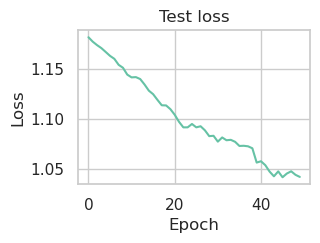

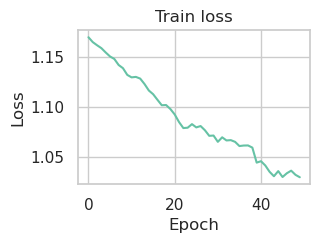

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


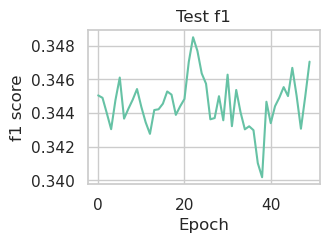

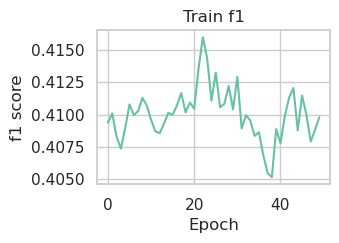

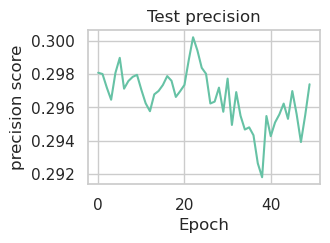

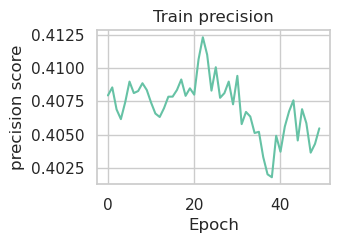

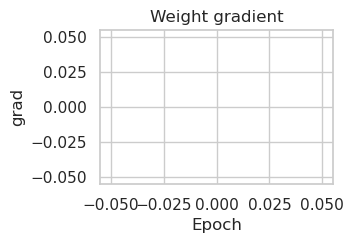

In [ ]:
train_enc_model_enc_data(learning_rate=1e-7, l1=0.005, epochs=50) # 1st polynommial